In [223]:
from itertools import combinations
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
import joblib
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.api.types import is_numeric_dtype
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler, SMOTEN
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibrationDisplay
from matplotlib.ticker import PercentFormatter
import shap

Estamos refinando o conjunto de dados principal para atender a um objetivo comercial claro: criar um modelo que preveja o resultado acad√™mico final de um aluno. Para fazer isso de forma eficaz, o modelo deve ser treinado em dados com resultados hist√≥ricos confirmados. Os registros de alunos que ainda est√£o ‚ÄúMatriculados‚Äù representam um status incerto, em andamento, e n√£o um resultado final. A inclus√£o dessa ambiguidade introduziria ru√≠do e comprometeria a capacidade do modelo de aprender os padr√µes distintos que diferenciam os alunos que acabam se formando dos que desistem.


O arquivo exportado que cont√©m os alunos ‚Äúmatriculados‚Äù √© preservado para a aplica√ß√£o principal do modelo. Depois que nosso modelo for treinado e validado nos dados hist√≥ricos, n√≥s o usaremos para prever os resultados futuros para esse grupo de ‚Äúmatriculados‚Äù. Isso nos permite gerar uma pontua√ß√£o de risco de evas√£o para cada aluno ativo no momento, permitindo que a institui√ß√£o identifique proativamente indiv√≠duos em risco e implemente interven√ß√µes direcionadas para melhorar a reten√ß√£o.

In [224]:
df = pd.read_csv('./data/dataset.csv')

enrolled_df = df[df['Target'] == 'Enrolled'].copy()
enrolled_df.to_csv('./data/enrolled_students.csv', index=False)

df = df[df['Target'] != 'Enrolled']

cols_to_convert_to_category = [
    'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
    'Previous qualification', 'Nacionality', "Mother's qualification", 
    "Father's qualification", "Mother's occupation", "Father's occupation", 
    'Displaced', 'Educational special needs', 'Debtor', "Target",
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

for col in cols_to_convert_to_category:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Analise Explorat√≥ria dos Dados

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  3630 non-null   category
 1   Application mode                                3630 non-null   category
 2   Application order                               3630 non-null   int64   
 3   Course                                          3630 non-null   category
 4   Daytime/evening attendance                      3630 non-null   category
 5   Previous qualification                          3630 non-null   category
 6   Nacionality                                     3630 non-null   category
 7   Mother's qualification                          3630 non-null   category
 8   Father's qualification                          3630 non-null   category
 9   Mother's occupation                

In [226]:
df.describe()

Application order  Age at enrollment  \
count        3630.000000        3630.000000   
mean            1.750138          23.461157   
std             1.333831           7.827994   
min             0.000000          17.000000   
25%             1.000000          19.000000   
50%             1.000000          20.000000   
75%             2.000000          25.000000   
max             6.000000          70.000000   

       Curricular units 1st sem (credited)  \
count                          3630.000000   
mean                              0.754270   
std                               2.477277   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              20.000000   

       Curricular units 1st sem (enrolled)  \
count                          3630.000000   
mean                              6.337466   
std                               2.570773   
min                               0.000000   
25%                               5.000000   
50%                               6.000000   
75%                               7.000000   
max                              26.000000   

       Curricular units 1st sem (evaluations)  \
count                             3630.000000   
mean                                 8.071074   
std                                  4.286632   
min                                  0.000000   
25%                                  6.000000   
50%                                  8.000000   
75%                                 10.000000   
max                                 45.000000   

       Curricular units 1st sem (approved)  Curricular units 1st sem (grade)  \
count                          3630.000000                       3630.000000   
mean                              4.791460                         10.534860   
std                               3.237845                          5.057694   
min                               0.000000                          0.000000   
25%                               3.000000                         11.000000   
50%                               5.000000                         12.341429   
75%                               6.000000                         13.500000   
max                              26.000000                         18.875000   

       Curricular units 1st sem (without evaluations)  \
count                                     3630.000000   
mean                                         0.128926   
std                                          0.679111   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                         12.000000   

       Curricular units 2nd sem (credited)  \
count                          3630.000000   
mean                              0.581818   
std                               2.022688   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              19.000000   

       Curricular units 2nd sem (enrolled)  \
count                          3630.000000   
mean                              6.296419   
std                               2.263020   
min                               0.000000   
25%                               5.000000   
50%                               6.000000   
75%                               7.000000   
max                              23.000000   

       Curricular units 2nd sem (evaluations)  \
count                             3630.000000   
mean                                 7.763085   
std                                  3.964163   
min                                  0.000000   
2

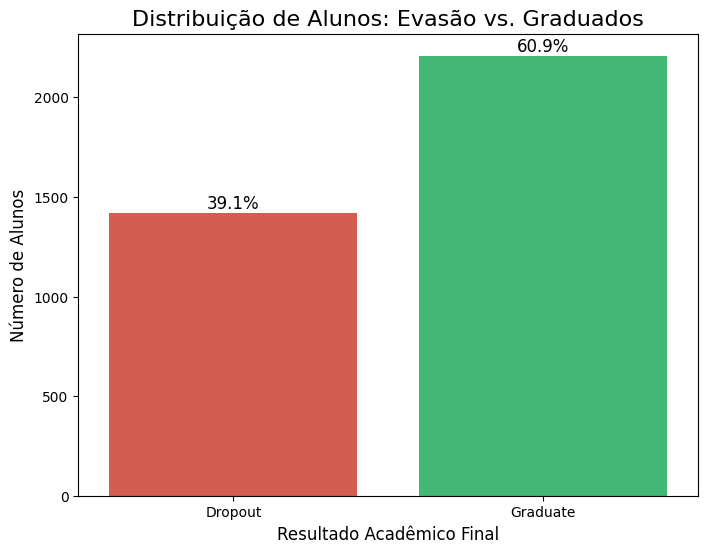

In [227]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Target', data=df, palette=['#E74C3C', '#2ECC71'])

plt.title('Distribui√ß√£o de Alunos: Evas√£o vs. Graduados', fontsize=16)
plt.xlabel('Resultado Acad√™mico Final', fontsize=12)
plt.ylabel('N√∫mero de Alunos', fontsize=12)

total = len(df['Target'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

Este gr√°fico mostra a propor√ß√£o exata entre evas√µes e formaturas. As classes est√£o muito desbalanceadas (ex: 60.9% de graduados e 39.1% de evas√£o), talvez seja necess√°rio usar t√©cnicas de amostragem (como SMOTE ou ADASYN), m√©tricas de avalia√ß√£o espec√≠ficas (como F1-Score) e uso de peso de classes durante a modelagem.

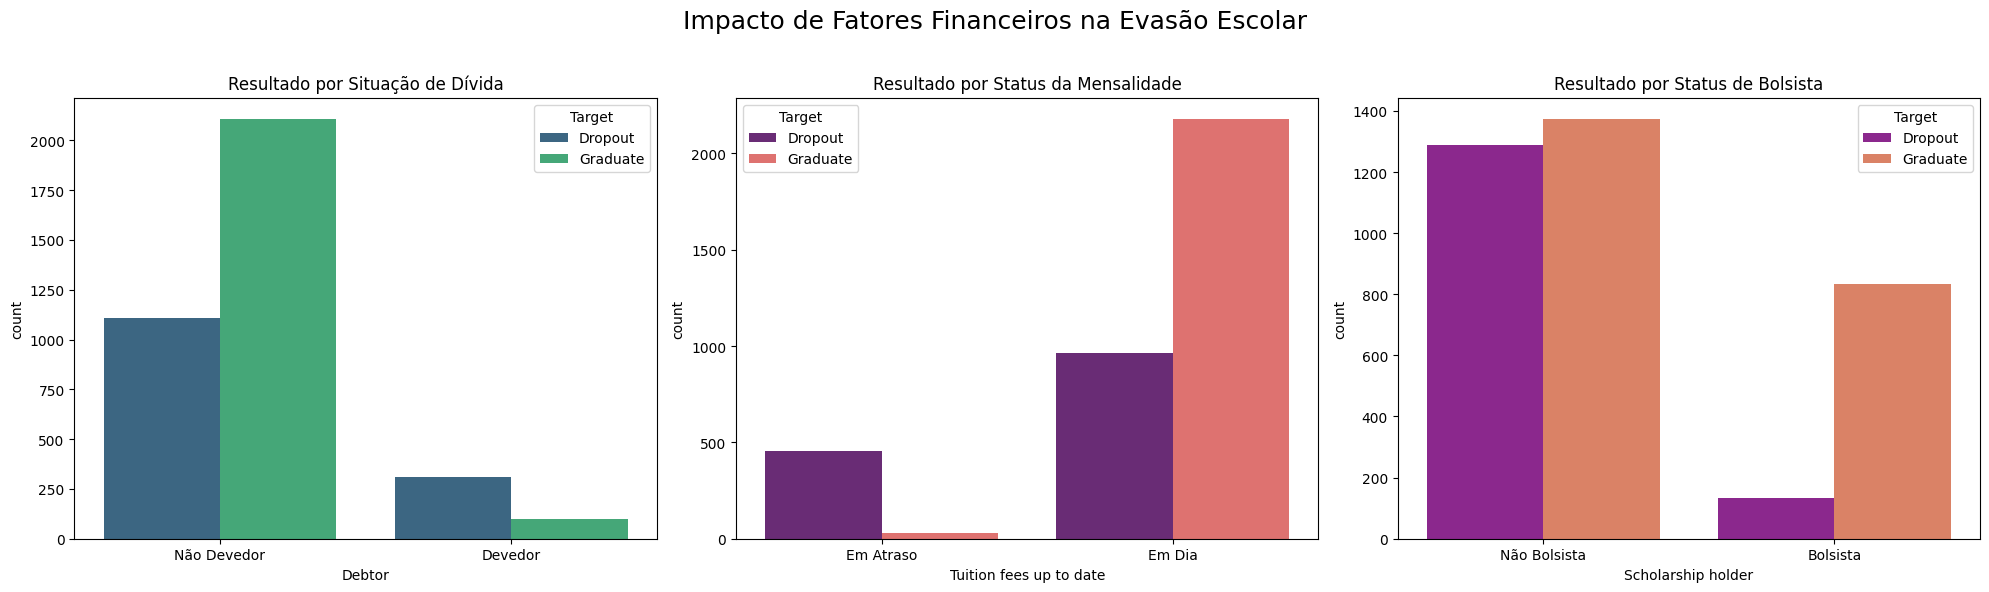

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Impacto de Fatores Financeiros na Evas√£o Escolar', fontsize=18)

sns.countplot(ax=axes[0], x='Debtor', hue='Target', data=df, palette='viridis')
axes[0].set_title('Resultado por Situa√ß√£o de D√≠vida')
axes[0].set_xticklabels(['N√£o Devedor', 'Devedor'])

sns.countplot(ax=axes[1], x='Tuition fees up to date', hue='Target', data=df, palette='magma')
axes[1].set_title('Resultado por Status da Mensalidade')
axes[1].set_xticklabels(['Em Atraso', 'Em Dia'])

sns.countplot(ax=axes[2], x='Scholarship holder', hue='Target', data=df, palette='plasma')
axes[2].set_title('Resultado por Status de Bolsista')
axes[2].set_xticklabels(['N√£o Bolsista', 'Bolsista'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Os gr√°ficos mostram que ter d√≠vidas ou mensalidades em atraso est√° fortemente correlacionado com a evas√£o. Por outro lado, ser bolsista tende a estar associado a uma maior taxa de gradua√ß√£o, possivelmente por reduzir a press√£o financeira e selecionar alunos com bom desempenho.

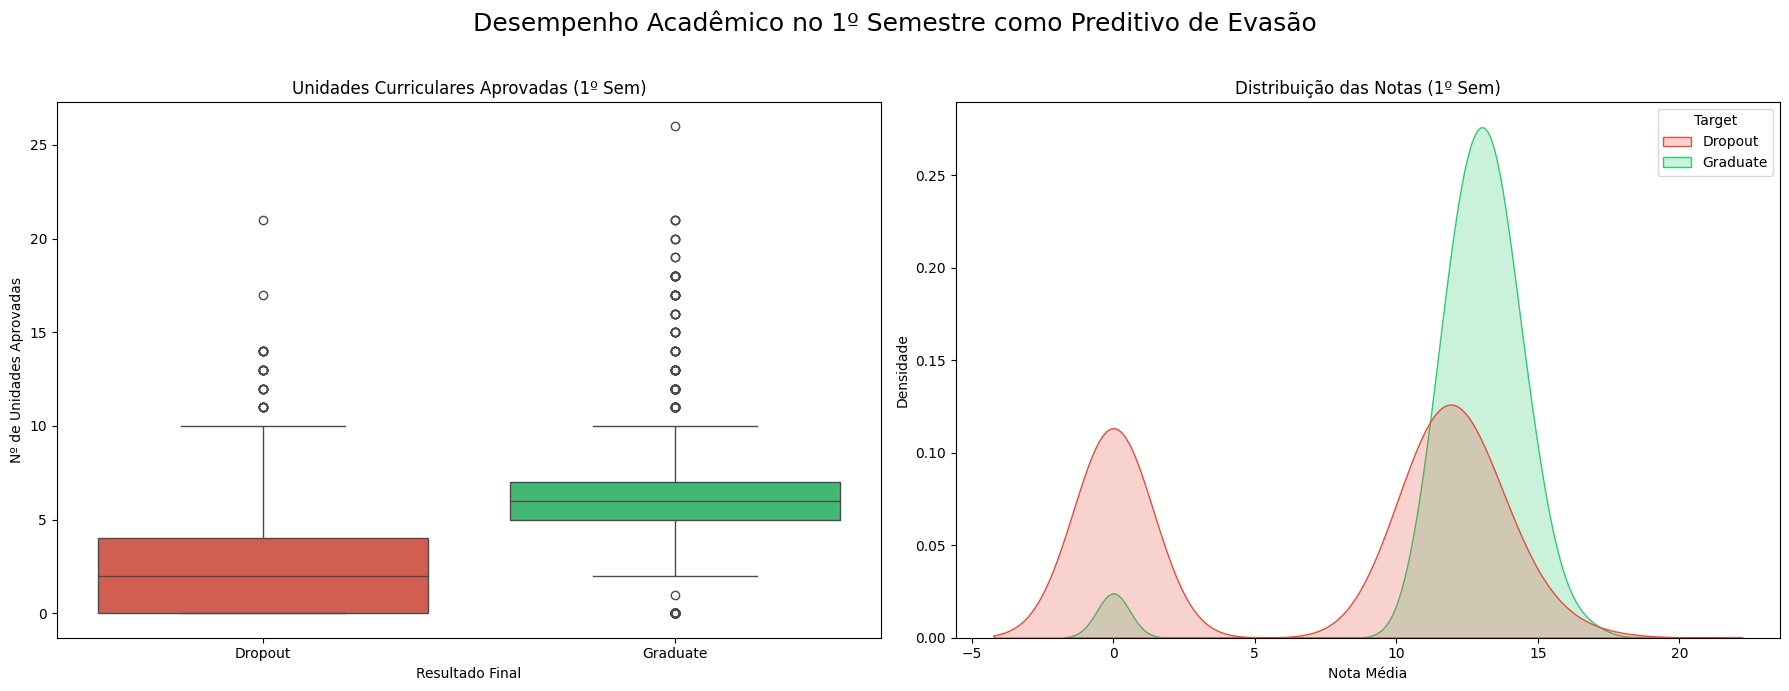

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Desempenho Acad√™mico no 1¬∫ Semestre como Preditivo de Evas√£o', fontsize=18)

sns.boxplot(ax=axes[0], x='Target', y='Curricular units 1st sem (approved)', data=df, palette=['#E74C3C', '#2ECC71'])
axes[0].set_title('Unidades Curriculares Aprovadas (1¬∫ Sem)')
axes[0].set_xlabel('Resultado Final')
axes[0].set_ylabel('N¬∫ de Unidades Aprovadas')


sns.kdeplot(data=df, x='Curricular units 1st sem (grade)', hue='Target',
            fill=True, common_norm=False, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Distribui√ß√£o das Notas (1¬∫ Sem)')
axes[1].set_xlabel('Nota M√©dia')
axes[1].set_ylabel('Densidade')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Fica evidente que alunos que aprovam mais mat√©rias e t√™m notas mais altas logo no primeiro semestre t√™m uma chance muito maior de se graduar. Uma baixa contagem de aprova√ß√µes √© um forte sinal de alerta precoce para a evas√£o.

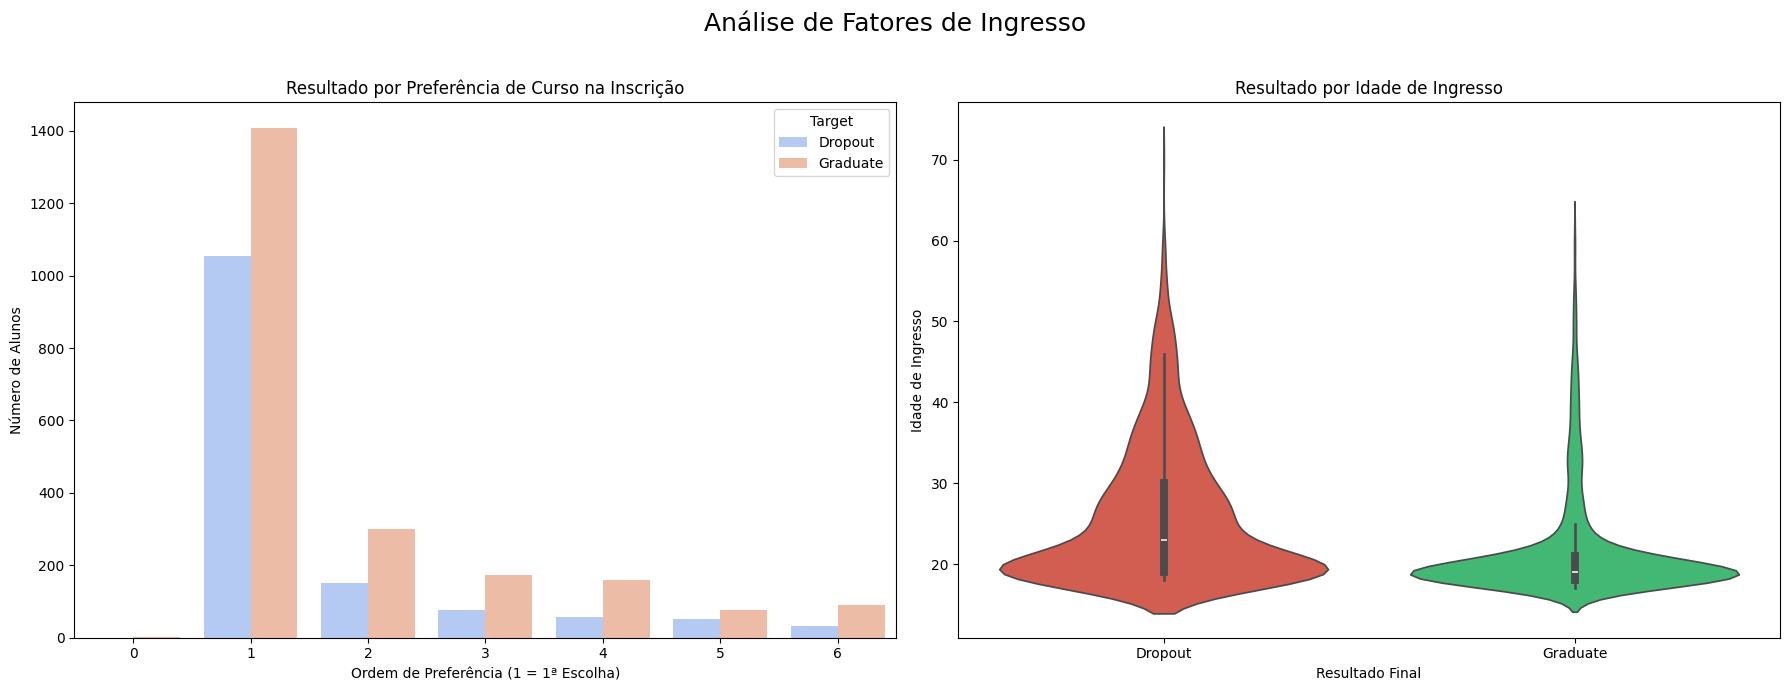

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('An√°lise de Fatores de Ingresso', fontsize=18)

sns.countplot(ax=axes[0], x='Application order', hue='Target', data=df, palette='coolwarm')
axes[0].set_title('Resultado por Prefer√™ncia de Curso na Inscri√ß√£o')
axes[0].set_xlabel('Ordem de Prefer√™ncia (1 = 1¬™ Escolha)')
axes[0].set_ylabel('N√∫mero de Alunos')

sns.violinplot(ax=axes[1], x='Target', y='Age at enrollment', data=df, palette=['#E74C3C', '#2ECC71'])
axes[1].set_title('Resultado por Idade de Ingresso')
axes[1].set_xlabel('Resultado Final')
axes[1].set_ylabel('Idade de Ingresso')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Alunos que entram no curso de primeira escolha (Application order = 1) intuitivamente tendem a ser mais motivados e, consequentemente, t√™m uma taxa de evas√£o menor, mas o grafico acima nos mostra que a propor√ß√£o de graduados e evas√£o continua a mesma quanto aumenta a Ordem de Prefer√™ncia. A an√°lise de idade pode revelar que alunos mais velhos (mature students) tem taxas de evas√£o ligeiramente maiores, talvez por terem que conciliar trabalho, estudo, fam√≠lia e outras responsabilidades que se tem quando √© mais velho.

## Analise Estat√≠stica

| Tipo de vari√°vel 1 | Tipo de vari√°vel 2 | Teste recomendado | Observa√ß√£o |
| :--- | :--- | :--- | :--- |
| Categ√≥rica | Categ√≥rica | Qui-quadrado (Chi-square) | Testa independ√™ncia entre categorias |
| Num√©rica | Num√©rica | Correla√ß√£o de Pearson (ou Spearman para n√£o param√©trico) | Mede for√ßa e dire√ß√£o da rela√ß√£o linear |
| Categ√≥rica | Num√©rica | ANOVA (ou teste t para 2 grupos) | Testa diferen√ßa das m√©dias da num√©rica entre grupos categ√≥ricos |
| Num√©rica | Categ√≥rica | ANOVA (mesma situa√ß√£o acima, s√≥ invertendo) | O teste √© sim√©trico neste caso |
| Categ√≥rica (target) | Num√©rica | Modelos de classifica√ß√£o (e.g., regress√£o log√≠stica) e testes espec√≠ficos | ANOVA n√£o √© indicado para associa√ß√£o com target categ√≥rico |
| Num√©rica (target) | Categ√≥rica | ANOVA (comparar m√©dias entre grupos da categ√≥rica) | Cl√°ssico caso para ANOVA |

### Matriz de correla√ß√£o de Pearson (Entre vari√°veis n√∫mericas)

√â uma tabela que mostra o grau de associa√ß√£o linear entre pares de vari√°veis num√©ricas.

Ela usa o coeficiente de correla√ß√£o de Pearson (r) para medir quanto duas vari√°veis se movem juntas, ou seja, o quanto aumentos ou diminui√ß√µes em uma vari√°vel se associam a aumentos ou diminui√ß√µes em outra.

| Valor de r | Interpreta√ß√£o |
| :--- | :--- |
| +1 | Correla√ß√£o linear positiva perfeita |
| 0 | Sem correla√ß√£o linear |
| -1 | Correla√ß√£o linear negativa perfeita |

**Importante**: Pearson s√≥ mede rela√ß√µes lineares. Duas vari√°veis podem ser dependentes n√£o-linearmente e ainda assim ter r ‚âà 0.

Para duas vari√°veis X e Y com n observa√ß√µes, o coeficiente de correla√ß√£o de Pearson r √© calculado como:

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}
         {\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \cdot \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$

Onde:
- $X·µ¢$ e $Y·µ¢$ s√£o os valores individuais das vari√°veis $X$ e $Y$
- $ùëãÃÑ$ e $ùëåÃÑ$ s√£o as m√©dias das vari√°veis $X$ e $Y$
- O numerador √© a covari√¢ncia entre $X$ e $Y$
- O denominador √© o produto dos desvios padr√£o de $X$ e $Y$

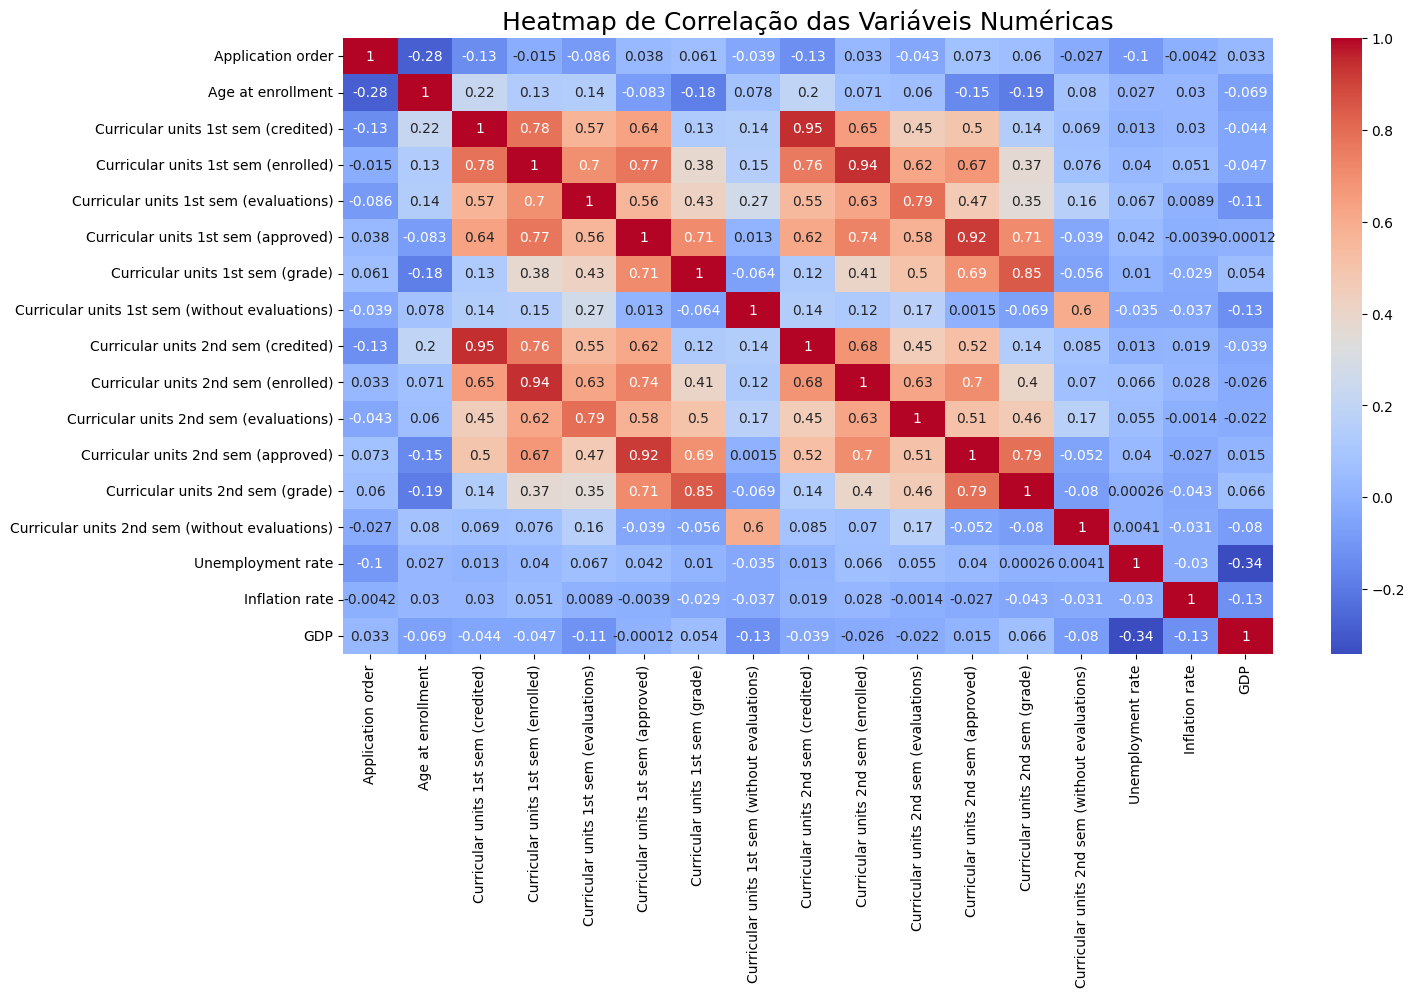

In [ ]:
numeric_cols = df.select_dtypes(include=np.number)

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Heatmap de Correla√ß√£o das Vari√°veis Num√©ricas', fontsize=18)
plt.show()

- **Dentro do mesmo semestre**: Vari√°veis como unidades matriculadas (enrolled), avaliadas (evaluations) e aprovadas (approved) s√£o fortemente correlacionadas. Isso √© l√≥gico: quem se matricula em mais mat√©rias tende a ter mais avalia√ß√µes e a ser aprovado em mais unidades. A nota do semestre (grade) tamb√©m tem uma correla√ß√£o muito forte com as unidades aprovadas (approved), com um valor de 0.71 no 1¬∫ semestre.

- **Entre semestres (Insight importante)**: A correla√ß√£o mais forte e importante √© entre o desempenho do 1¬∫ e do 2¬∫ semestre. A nota do 1¬∫ semestre (1st sem (grade)) tem uma correla√ß√£o de 0.85 com a do 2¬∫. Da mesma forma, as unidades aprovadas no 1¬∫ semestre t√™m correla√ß√£o de 0.92 com as do 2¬∫. Isso prova que o desempenho acad√™mico passado √© um preditor extremamente forte do desempenho futuro.

- **Poss√≠vel Multicolinearidade**: O "bloco quente" envolvendo as vari√°veis `Curricular units ...` s√£o um grande indicativo de multicolinearidade. Isso ser√° analisado posteriormente usando a t√©cnica de Fator de Infla√ß√£o de Vari√¢ncia (VIF).

### Testes de Hip√≥tese


#### ANOVA (An√°lise de Vari√¢ncia): 
Testa se existe uma diferen√ßa estatisticamente significativa entre as m√©dias de uma vari√°vel num√©rica em dois ou mais grupos de uma vari√°vel categ√≥rica

- **ANOVA pergunta**: "Essa vari√°vel categ√≥rica est√° associada a diferen√ßas significativas na m√©dia de uma vari√°vel cont√≠nua?"
    - Se sim, ela traz informa√ß√£o √∫til e pode ser uma boa candidata como vari√°vel explicativa.

1. **Hip√≥tese nula** ($H_0$):
    - N√£o h√° diferen√ßa significativa entre os grupos.
    - Ou seja: a vari√°vel categ√≥rica n√£o tem efeito sobre a vari√°vel num√©rica.
    - As m√©dias dos grupos (categorias) s√£o iguais.

‚û° Isso implica que n√£o h√° associa√ß√£o estat√≠stica entre as vari√°veis. √â poss√≠vel considerar o descarte de uma das vari√°veis, ou realizar um feature engineering.

2. **Hip√≥tese alternativa** ($H_1$):
    - H√° pelo menos uma diferen√ßa significativa entre os grupos.
    - Ou seja: a vari√°vel categ√≥rica tem efeito sobre a vari√°vel num√©rica.
    - As m√©dias dos grupos s√£o diferentes.

‚û° Isso indica associa√ß√£o significativa entre a vari√°vel categ√≥rica e a num√©rica. Feature engineering pode n√£o ser necess√°ria nesse ponto, porque a rela√ß√£o j√° est√° clara, mas ainda pode valer a pena melhorar a representa√ß√£o.

- $p > 0.05$ >>> N√£o rejeita $H_0$ ‚Üí N√£o h√° evid√™ncia de diferen√ßa entre os grupos ‚Üí Sem associa√ß√£o
- $p ‚â§ 0.05$ >>> Rejeita $H_0$ e aceita $H_1$ ‚Üí Existe evid√™ncia de que os grupos diferem ‚Üí H√° associa√ß√£o

In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

if 'Target' in categorical_features:
    categorical_features.remove('Target')

anova_results = []

for cat_col in categorical_features:
    for num_col in numerical_features:
        # Pular se a vari√°vel categ√≥rica tiver muitas categorias (torna o teste lento/ruim)
        if df[cat_col].nunique() > 50:
            continue
            
        # Agrupar os dados num√©ricos pelas categorias da vari√°vel categ√≥rica
        groups = df.groupby(cat_col)[num_col].apply(list)
        
        if len(groups) < 2:
            continue
        
        try:
            f_statistic, p_value = f_oneway(*groups)
            anova_results.append({
                'Vari√°vel Categ√≥rica': cat_col,
                'Vari√°vel Num√©rica': num_col,
                'Estat√≠stfor o n√∫cleoica F': f_statistic,
                'p-valor': p_value
            })
        except Exception as e:
            # Ignorar pares que causam erros (ex: grupos com dados insuficientes)
            pass

results_df = pd.DataFrame(anova_results)

results_df_sorted = results_df.sort_values(by='p-valor', ascending=True)

print("Exibindo as 15 rela√ß√µes mais significativas:")
display(results_df_sorted.head(15))

print("Exibindo as 15 rela√ß√µes menos significativas:")
display(results_df_sorted.tail(15))


Exibindo as 15 rela√ß√µes mais significativas:


Vari√°vel Categ√≥rica  ...        p-valor
18             Application mode  ...   0.000000e+00
1                Marital status  ...   0.000000e+00
43                       Course  ...  1.049518e-315
35                       Course  ...  6.580430e-225
37                       Course  ...  1.995195e-205
19             Application mode  ...  1.850651e-201
69       Previous qualification  ...  1.607919e-200
52   Daytime/evening attendance  ...  7.200418e-184
25             Application mode  ...  7.155714e-177
40                       Course  ...  2.246295e-172
103      Mother's qualification  ...  2.124312e-148
45                       Course  ...  4.011635e-139
46                       Course  ...  3.911730e-131
38                       Course  ...  6.445531e-125
171                   Displaced  ...  3.594256e-118

[15 rows x 4 columns]

Exibindo as 15 rela√ß√µes menos significativas:


Vari√°vel Categ√≥rica  ...   p-valor
276               International  ...  0.685916
280               International  ...  0.707180
162         Father's occupation  ...  0.707389
287               International  ...  0.721909
265          Scholarship holder  ...  0.722193
277               International  ...  0.737792
67   Daytime/evening attendance  ...  0.762961
253                      Gender  ...  0.787921
202   Educational special needs  ...  0.788594
97                  Nacionality  ...  0.791122
91                  Nacionality  ...  0.821266
275               International  ...  0.831210
284               International  ...  0.853486
160         Father's occupation  ...  0.863999
278               International  ...  0.901435

[15 rows x 4 columns]

- **Idade de Ingresso (Age at enrollment) √© Central**: A idade do aluno √© a vari√°vel num√©rica mais influenciada por fatores categ√≥ricos. Ela est√° fortemente associada ao Estado Civil, Modo de Aplica√ß√£o, Curso, Qualifica√ß√£o Pr√©via e se o aluno √© Deslocado. Isso indica que diferentes perfis demogr√°ficos ingressam na universidade em idades significativamente diferentes, o que, por si s√≥, √© um poderoso agrupador de comportamento.

- **O Curso (Course) Define o Desempenho**: Como esperado, o curso escolhido tem um impacto massivo em todas as m√©tricas de desempenho acad√™mico: unidades matriculadas (enrolled), notas (grade) e unidades aprovadas (approved). Isso confirma que a dificuldade e a carga de trabalho variam drasticamente entre os cursos, tornando esta uma das features mais importantes para prever o sucesso de um aluno.

- **O Hist√≥rico Importa**: A Qualifica√ß√£o Pr√©via (Previous qualification) e o Modo de Aplica√ß√£o (Application mode) est√£o fortemente ligados tanto √† idade quanto aos cr√©ditos iniciais. Isso mostra que a "bagagem" que o aluno traz para a universidade j√° o coloca em uma trajet√≥ria de desempenho distinta.

- **Status de International √© um Preditor Fraco (Isoladamente)**: A descoberta mais not√°vel aqui √© que ser ou n√£o um estudante internacional n√£o tem uma associa√ß√£o estatisticamente significativa com quase nenhuma m√©trica de desempenho acad√™mico (notas, aprova√ß√µes, avalia√ß√µes). Isso sugere que, neste dataset, o desempenho dos alunos internacionais √© estatisticamente indistingu√≠vel do dos alunos nacionais, tornando essa vari√°vel, sozinha, um preditor fraco.

- **Demografia Secund√°ria com Baixo Impacto**: Vari√°veis como Ocupa√ß√£o do Pai (Father's occupation), Nacionalidade (Nacionality) e G√™nero (Gender), quando cruzadas com as m√©tricas num√©ricas, mostraram uma rela√ß√£o muito fraca (p-valor alto). Elas provavelmente t√™m menos poder preditivo direto do que as vari√°veis da primeira tabela.

- **Fatores Macroecon√¥micos Difusos**: A Taxa de Infla√ß√£o e o PIB n√£o se mostraram associados a caracter√≠sticas individuais como g√™nero ou nacionalidade, o que faz sentido, pois s√£o indicadores que afetam a todos de forma mais ampla e menos direta.


#### Qui-Quadrado

Este teste avalia se existe uma associa√ß√£o estatisticamente significativa entre duas vari√°veis categ√≥ricas. A hip√≥tese nula $H_0‚Äã$ √© que as vari√°veis s√£o independentes (n√£o h√° associa√ß√£o, com $p > 0.05$) e a hip√≥tese alternativa $H_1$ √© que existe uma associa√ß√£o ($p ‚â§ 0.05$).

O Qui-Quadrado consegue analisar associa√ß√µes entre a nossa vari√°vel Target (que √© categ√≥rica) e outras vari√°veis explicativas categ√≥ricas.

**OBS**: A ANOVA analisa o impacto de uma vari√°vel categ√≥rica nas m√©dias de uma vari√°vel num√©rica, A vari√°vel categ√≥rica define os grupos (por exemplo: `aprovado`, `reprovado`, `evadiu`), e a vari√°vel num√©rica √© a que est√° sendo analisada em rela√ß√£o √†s diferen√ßas entre esses grupos (ex: m√©dia de notas, horas de estudo, renda etc.). No nosso caso, queremos sabe se a vari√°vel categ√≥rica `Target` (evas√£o escolar) pode ser explicada por uma vari√°vel num√©rica (ex: renda, idade, nota), acontece que a ANOVA n√£o foi projetada para testar isso diretamente, porque o foco da ANOVA est√° na vari√°vel num√©rica como vari√°vel de interesse, e a categ√≥rica como vari√°vel explicativa, e n√£o o contr√°rio. O teste de **Qui-quadrado** entra para resolver esse problema.

Rela√ß√µes mais significativas:


Vari√°vel 1  ...        p-valor
20          Application mode  ...   0.000000e+00
19          Application mode  ...   0.000000e+00
33                    Course  ...   0.000000e+00
108      Mother's occupation  ...   0.000000e+00
87    Mother's qualification  ...   0.000000e+00
85               Nacionality  ...   0.000000e+00
89    Mother's qualification  ...   0.000000e+00
88    Mother's qualification  ...   0.000000e+00
99    Father's qualification  ...   0.000000e+00
98    Father's qualification  ...  3.329569e-294
17          Application mode  ...  6.859661e-240
31          Application mode  ...  1.606752e-183
146  Tuition fees up to date  ...  9.189124e-156
0             Marital status  ...  1.831588e-155
138                   Debtor  ...  1.843163e-150
25          Application mode  ...  4.355530e-127
18          Application mode  ...  4.505609e-124
44                    Course  ...  1.132511e-121
2             Marital status  ...   2.233328e-98
47                    Course  ...   3.497695e-84

[20 rows x 4 columns]



Associa√ß√µes mais fortes com a vari√°vel 'Target':


Vari√°vel 1 Vari√°vel 2  Estat√≠stica Chi2        p-valor
146     Tuition fees up to date     Target        706.955139  9.189124e-156
47                       Course     Target        442.947968   3.497695e-84
151          Scholarship holder     Target        354.219302   5.109075e-79
32             Application mode     Target        392.065918   8.435153e-73
142                      Debtor     Target        257.459618   6.141424e-58
149                      Gender     Target        229.351510   8.255974e-52
74       Previous qualification     Target        150.599021   5.952453e-24
97       Mother's qualification     Target        143.014288   2.201217e-17
116         Mother's occupation     Target        138.235113   1.555138e-16
107      Father's qualification     Target        147.861704   1.754550e-16
131                   Displaced     Target         57.215216   3.906373e-14
124         Father's occupation     Target        125.427955   1.725336e-10
16               Marital status     Target         53.131403   3.160761e-10
61   Daytime/evening attendance     Target         25.371410   4.728747e-07
86                  Nacionality     Target         19.850806   3.412815e-01
137   Educational special needs     Target          0.075160   7.839673e-01
152               International     Target          0.067922   7.943867e-01

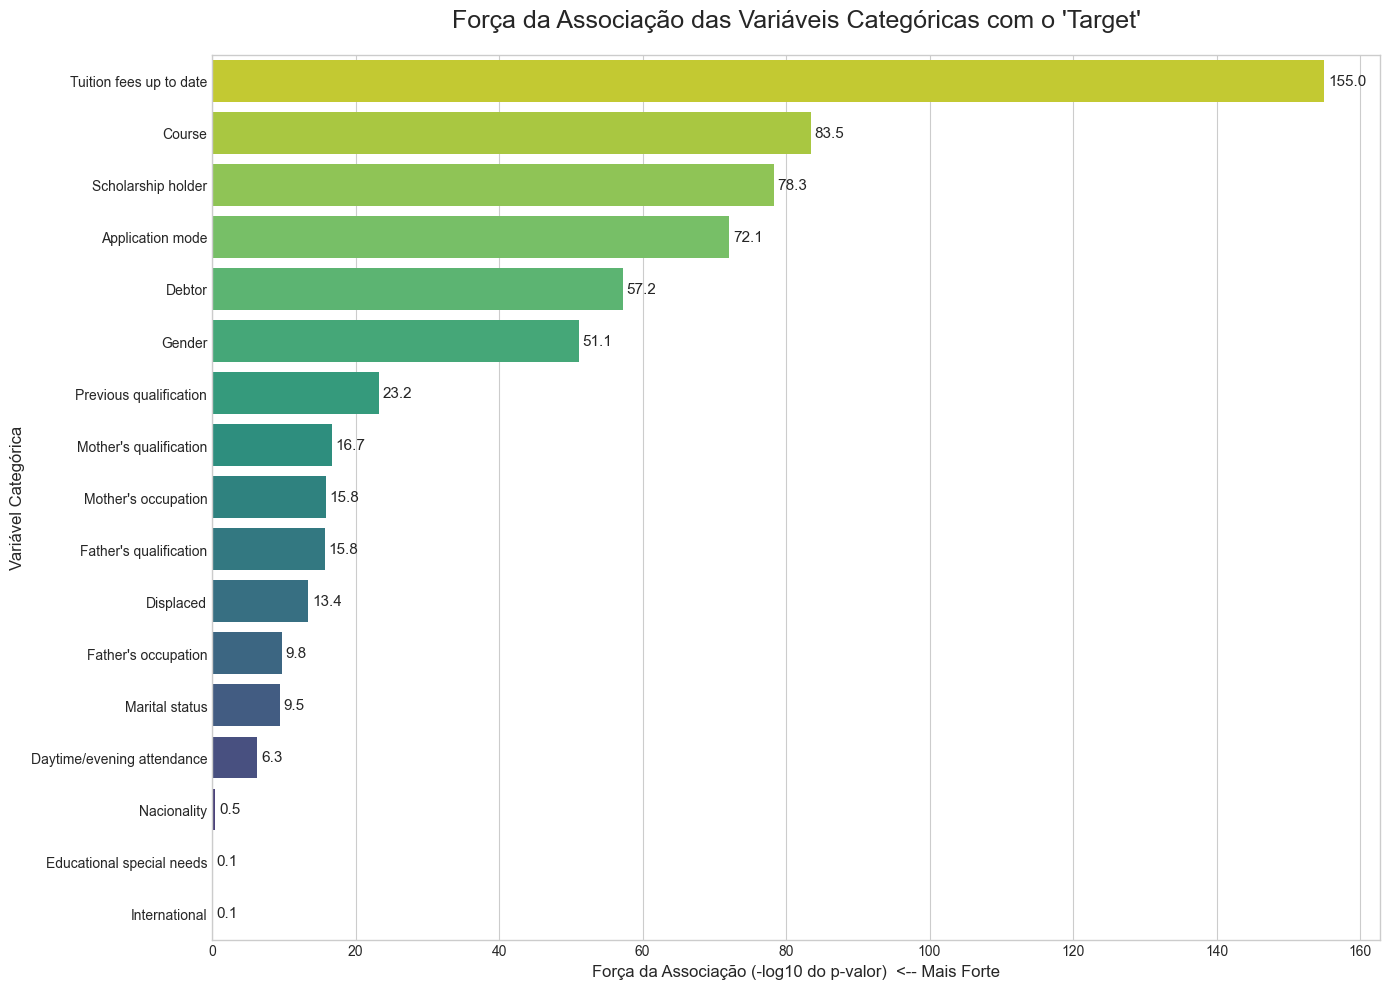

In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_pairs = list(combinations(categorical_features, 2))
chi2_results = []

for pair in cat_pairs:
    var1, var2 = pair[0], pair[1]
    
    contingency_table = pd.crosstab(df[var1], df[var2])
    
    try:
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_results.append({
            'Vari√°vel 1': var1,
            'Vari√°vel 2': var2,
            'Estat√≠stica Chi2': chi2,
            'p-valor': p_value
        })
    except Exception as e:
        # Algumas tabelas podem ter contagens zero, o que pode falhar o teste
        pass

results_df = pd.DataFrame(chi2_results)

results_df_sorted = results_df.sort_values(by='p-valor', ascending=True)

print("Rela√ß√µes mais significativas:")
display(results_df_sorted.head(20))

print("\n\nAssocia√ß√µes mais fortes com a vari√°vel 'Target':")
target_associations = results_df_sorted[
    (results_df_sorted['Vari√°vel 1'] == 'Target') | (results_df_sorted['Vari√°vel 2'] == 'Target')
].copy()
display(target_associations.head(20))

target_associations['Feature'] = target_associations.apply(
    lambda row: row['Vari√°vel 1'] if row['Vari√°vel 2'] == 'Target' else row['Vari√°vel 2'],
    axis=1
)

target_associations['For√ßa da Associa√ß√£o (-log10 p-valor)'] = -np.log10(target_associations['p-valor'].replace(0, 1e-300))

plot_data = target_associations.sort_values(by='For√ßa da Associa√ß√£o (-log10 p-valor)', ascending=False)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=plot_data,
    x='For√ßa da Associa√ß√£o (-log10 p-valor)',
    y='Feature',
    palette='viridis_r',
    orient='h'
)

ax.set_title("For√ßa da Associa√ß√£o das Vari√°veis Categ√≥ricas com o 'Target'", fontsize=18, pad=20)
ax.set_xlabel('For√ßa da Associa√ß√£o (-log10 do p-valor)  <-- Mais Forte', fontsize=12)
ax.set_ylabel('Vari√°vel Categ√≥rica', fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5, p.get_y() + p.get_height() / 2,
            f'{width:.1f}',
            va='center',
            fontsize=11)

plt.tight_layout()
plt.show()


##### Tier 1: Os Preditores Dominantes (p-valor $< e-50$)

Estas s√£o as vari√°veis com a conex√£o mais forte com a evas√£o. Elas devem estar presentes em qualquer modelo preditivo que for constru√≠do.

- **Tuition fees up to date (Mensalidades em dia)**: Com um p-valor astron√¥mico de aproximadamente $e^-156$, esta √©, de longe, a vari√°vel mais impactante. A associa√ß√£o √© t√£o forte que o status financeiro do aluno com a institui√ß√£o √© quase um veredito sobre seu resultado. A mensagem √© clara: dificuldade financeira √© a principal causa de evas√£o.

- **Course (Curso)**: A segunda vari√°vel mais forte. Confirma que o curso escolhido pelo aluno √© um fator determinante para seu sucesso. Alguns cursos podem ter taxas de evas√£o intrinsecamente mais altas devido √† dificuldade, estrutura ou alinhamento com o mercado.

- **Scholarship holder (Bolsista)**: Funciona como o oposto do status da mensalidade. Ter uma bolsa, que alivia a press√£o financeira e muitas vezes seleciona alunos de alto m√©rito, tem um efeito protetor massivo contra a evas√£o.

- **Application mode (Modo de Ingresso) e Debtor (Devedor)**: Completam este grupo de vari√°veis significativas. O caminho pelo qual o aluno entrou na universidade e seu status de d√≠vida s√£o fatores cr√≠ticos.

- **Gender (G√™nero)**: Surpreendentemente, G√™nero aparece com uma associa√ß√£o extremamente forte. Isso n√£o significa que um g√™nero seja "melhor" que o outro, mas sim que, neste dataset, os padr√µes de evas√£o e gradua√ß√£o entre homens e mulheres s√£o estatisticamente muito diferentes. Seria interessante investigar isso mais a fundo (ex: evas√£o por g√™nero dentro de cada curso).

Insight Principal do Tier 1: A sa√∫de financeira do aluno e suas escolhas acad√™micas prim√°rias s√£o os pilares que sustentam sua jornada na universidade.

##### Tier 2: Os Fatores de Contexto (p-valor entre $e-10$ e $e-24$)

Estas vari√°veis, embora n√£o t√£o dominantes quanto as do Tier 1, ainda s√£o preditores muito fortes e adicionam um √≥timo contexto sobre o perfil do aluno.

- **Qualifica√ß√£o e Ocupa√ß√£o dos Pais (Mother's/Father's qualification/occupation)**: Este bloco de vari√°veis age como um forte indicador do background socioecon√¥mico e cultural do aluno. Um n√≠vel educacional mais alto dos pais est√° claramente associado a uma menor chance de evas√£o, provavelmente por indicar um ambiente familiar que valoriza mais a educa√ß√£o e oferece maior suporte.

- **Hist√≥rico Acad√™mico (Previous qualification)**: A forma√ß√£o anterior do aluno continua sendo um preditor robusto do seu sucesso futuro.

- **Circunst√¢ncias Pessoais (Displaced, Marital status, Daytime/evening attendance)**: Fatores que descrevem a "vida fora da universidade" do aluno tamb√©m t√™m um peso significativo. Ser deslocado (longe de casa), o estado civil e estudar √† noite (geralmente indicando um trabalho simult√¢neo) s√£o circunst√¢ncias que impactam diretamente a capacidade do aluno de se manter no curso.

Insight Principal do Tier 2: O contexto social, familiar e pessoal do aluno fornece a segunda camada mais importante de informa√ß√£o preditiva.

##### Tier 3: Preditores Marginais ou Fracos (p-valor $> e-01$)

Estas vari√°veis est√£o na parte inferior da lista e devem ser tratadas com cautela, pois podem adicionar mais ru√≠do a um modelo do que ajudar na previs√£o da vari√°vel target.

- **Nacionality (Nacionalidade)**: Embora ainda seja estatisticamente significativa (p-valor ~0.034 < 0.05), sua for√ßa de associa√ß√£o √© ordens de magnitude mais fraca que a dos outros grupos. Ela pode adicionar alguma informa√ß√£o, mas seu impacto √© pequeno.

- **Educational special needs (Necessidades Especiais) e International (Internacional)**: Com p-valores de ~0.78 e ~0.79, respectivamente, estas vari√°veis n√£o t√™m uma associa√ß√£o estatisticamente significativa com o Target. Isso confirma o que j√° hav√≠amos visto no teste ANOVA para International. Isso pode significar que o suporte da institui√ß√£o para esses grupos √© eficaz, ou que outros fatores s√£o t√£o dominantes que anulam o efeito isolado dessas condi√ß√µes.

Insight Principal do Tier 3: Contrariando o senso comum, ser um estudante internacional ou ter uma necessidade especial registrada n√£o s√£o, por si s√≥, fatores de risco para evas√£o neste dataset

### Fator de Infla√ß√£o de Vari√¢ncia (VIF) - Diagn√≥stico de Multicolinearidade

Para uma vari√°vel $X_i$, o $VIF$ √© definido como:

$$
\text{VIF}_i = \frac{1}{1 - R_i^2}
$$

Onde:

- $R_i^2$ √© o coeficiente de determina√ß√£o da regress√£o da vari√°vel $X_i$ sobre todas as outras vari√°veis explicativas.

O VIF pergunta: "Essa vari√°vel est√° altamente correlacionada com as demais vari√°veis do modelo?"
- Se sim, traz redund√¢ncia e pode prejudicar a interpreta√ß√£o da regress√£o.

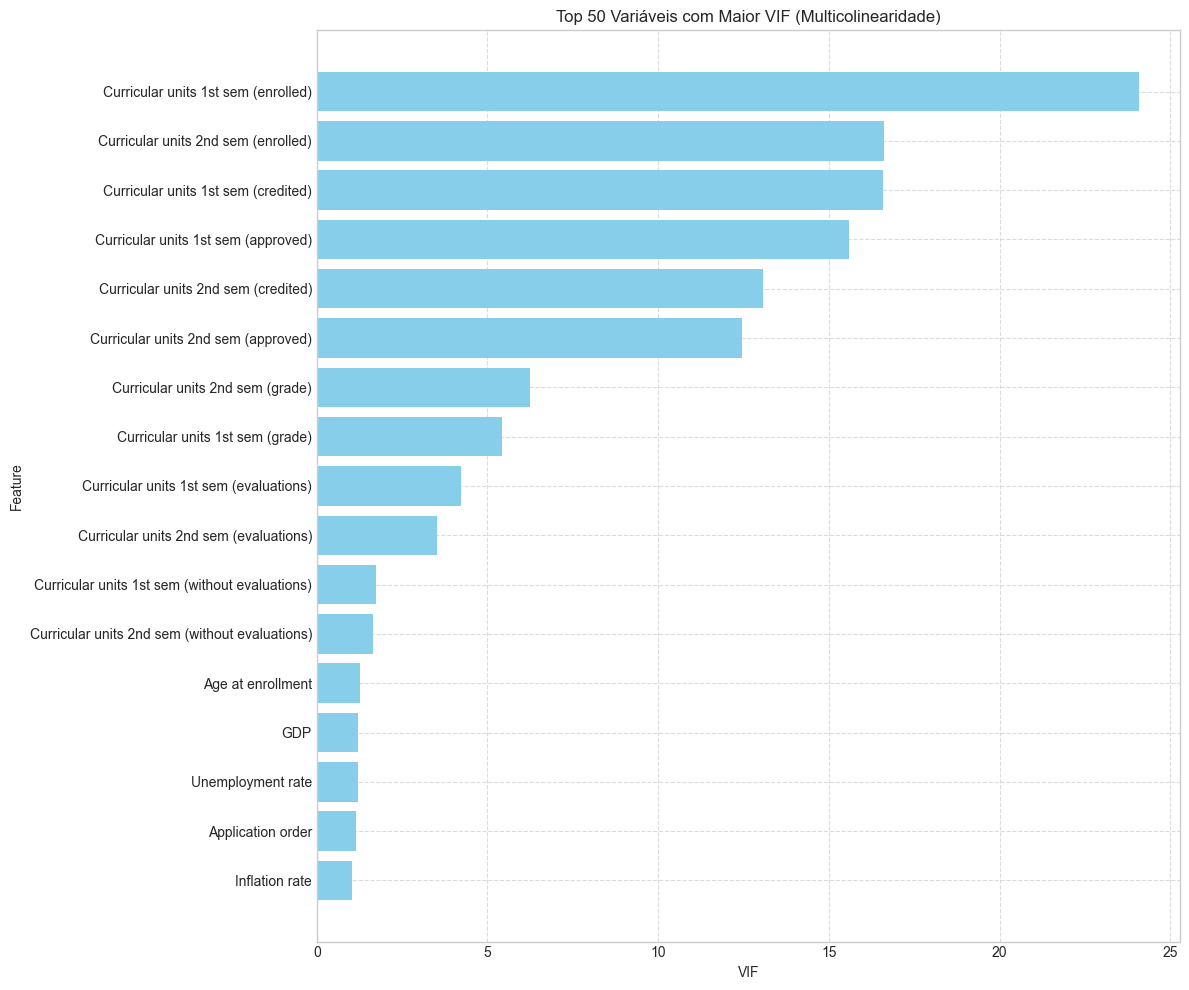

In [ ]:
# X_dum = pd.get_dummies(df, drop_first=True)
# X_dum = X_dum.astype(float)
# X_const = add_constant(X_dum)

X_numeric = df.select_dtypes(include=np.number).dropna()
X_const = add_constant(X_numeric)

vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

top_vif = vif_data[vif_data['feature'] != 'const'].sort_values("VIF", ascending=False).head(50)

plt.figure(figsize=(12, 10))
plt.barh(top_vif["feature"], top_vif["VIF"], color="skyblue")
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.title("Top 50 Vari√°veis com Maior VIF (Multicolinearidade)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Interpreta√ß√£o dos Valores de VIF

- $VIF = 1$ : Sem multicolinearidade 
- $1 < VIF < 5$ : Baixa multicolinearidade 
- $5 < VIF < 10$ : Moderada multicolinearidade (aten√ß√£o)
- $VIF > 10$ : Alta multicolinearidade (problem√°tico)

Um valor alto de VIF √© problem√°tico por v√°rias raz√µes. Primeiro, ele indica coeficientes inst√°veis, pois o modelo tem dificuldade em distinguir os efeitos individuais das vari√°veis correlacionadas. Al√©m disso, h√° redund√¢ncia, j√° que a vari√°vel com VIF alto geralmente n√£o adiciona nova informa√ß√£o, podendo ser prevista pelas demais. Isso tamb√©m pode levar a overfitting, pois o modelo se ajusta em excesso aos dados de treino ao incorporar vari√°veis que n√£o contribuem efetivamente para a explica√ß√£o da vari√°vel alvo. Por fim, h√° uma dificuldade de interpreta√ß√£o, j√° que se torna confuso identificar qual vari√°vel est√° realmente impactando a resposta.


- **VIF Extremamente Alto (> 10)**: As vari√°veis Curricular units 1st/2nd sem (enrolled), (credited) e (approved) apresentam VIFs alt√≠ssimos, chegando a 24.08. Isso significa que mais de 95% da vari√¢ncia de Curricular units 1st sem (enrolled) pode ser explicada pelas outras vari√°veis num√©ricas.
- **VIF Alto (> 5)**: As vari√°veis de notas (grade) tamb√©m mostram um VIF elevado.

**Insight Principal**: Isso √© totalmente esperado e l√≥gico. O n√∫mero de mat√©rias em que um aluno se matricula (enrolled), o n√∫mero de mat√©rias que ele valida (credited) e o n√∫mero que ele passa (approved) est√£o intrinsecamente ligados. S√£o diferentes medidas do mesmo conceito fundamental: o volume e o sucesso acad√™mico do aluno em um semestre.

A alta multicolinearidade no bloco acad√™mico pode ser um problema, especialmente para modelos lineares (como Regress√£o Log√≠stica), pois torna os coeficientes do modelo inst√°veis e dif√≠ceis de interpretar.

##### Poss√≠veis Estrat√©gias

- Remo√ß√£o cuidadosa das features com VIF alto;
- Feature Engineering: combinar as vari√°veis correlacionadas para criar novas features mais poderosas e que resolvam a multicolinearidade.
- Usar modelos naturalmente mais robustos √† multicolinearidade, como Random Forest, LightGBM, XGBoost, e outrosbaseados em ensemble.

### An√°lise de Assimetria (Skewness) e Detec√ß√£o de Outliers


A assimetria mede o grau de distor√ß√£o da distribui√ß√£o de uma vari√°vel em rela√ß√£o a uma distribui√ß√£o sim√©trica (curva de sino). Outliers s√£o pontos de dados que se desviam drasticamente dos demais.

Por que usar?

- Alguns modelos como Regress√£o Linear e SVMs funcionam melhor com dados que t√™m uma distribui√ß√£o pr√≥xima da normal (baixa assimetria).

- Identificar outliers nos ajuda a entender se s√£o erros de digita√ß√£o que precisam ser corrigidos ou se s√£o casos extremos e leg√≠timos que cont√™m informa√ß√µes importantes sobre o comportamento dos alunos.


--- Gr√°ficos de Densidade de Kernel (KDE) ---


KeyboardInterrupt: 

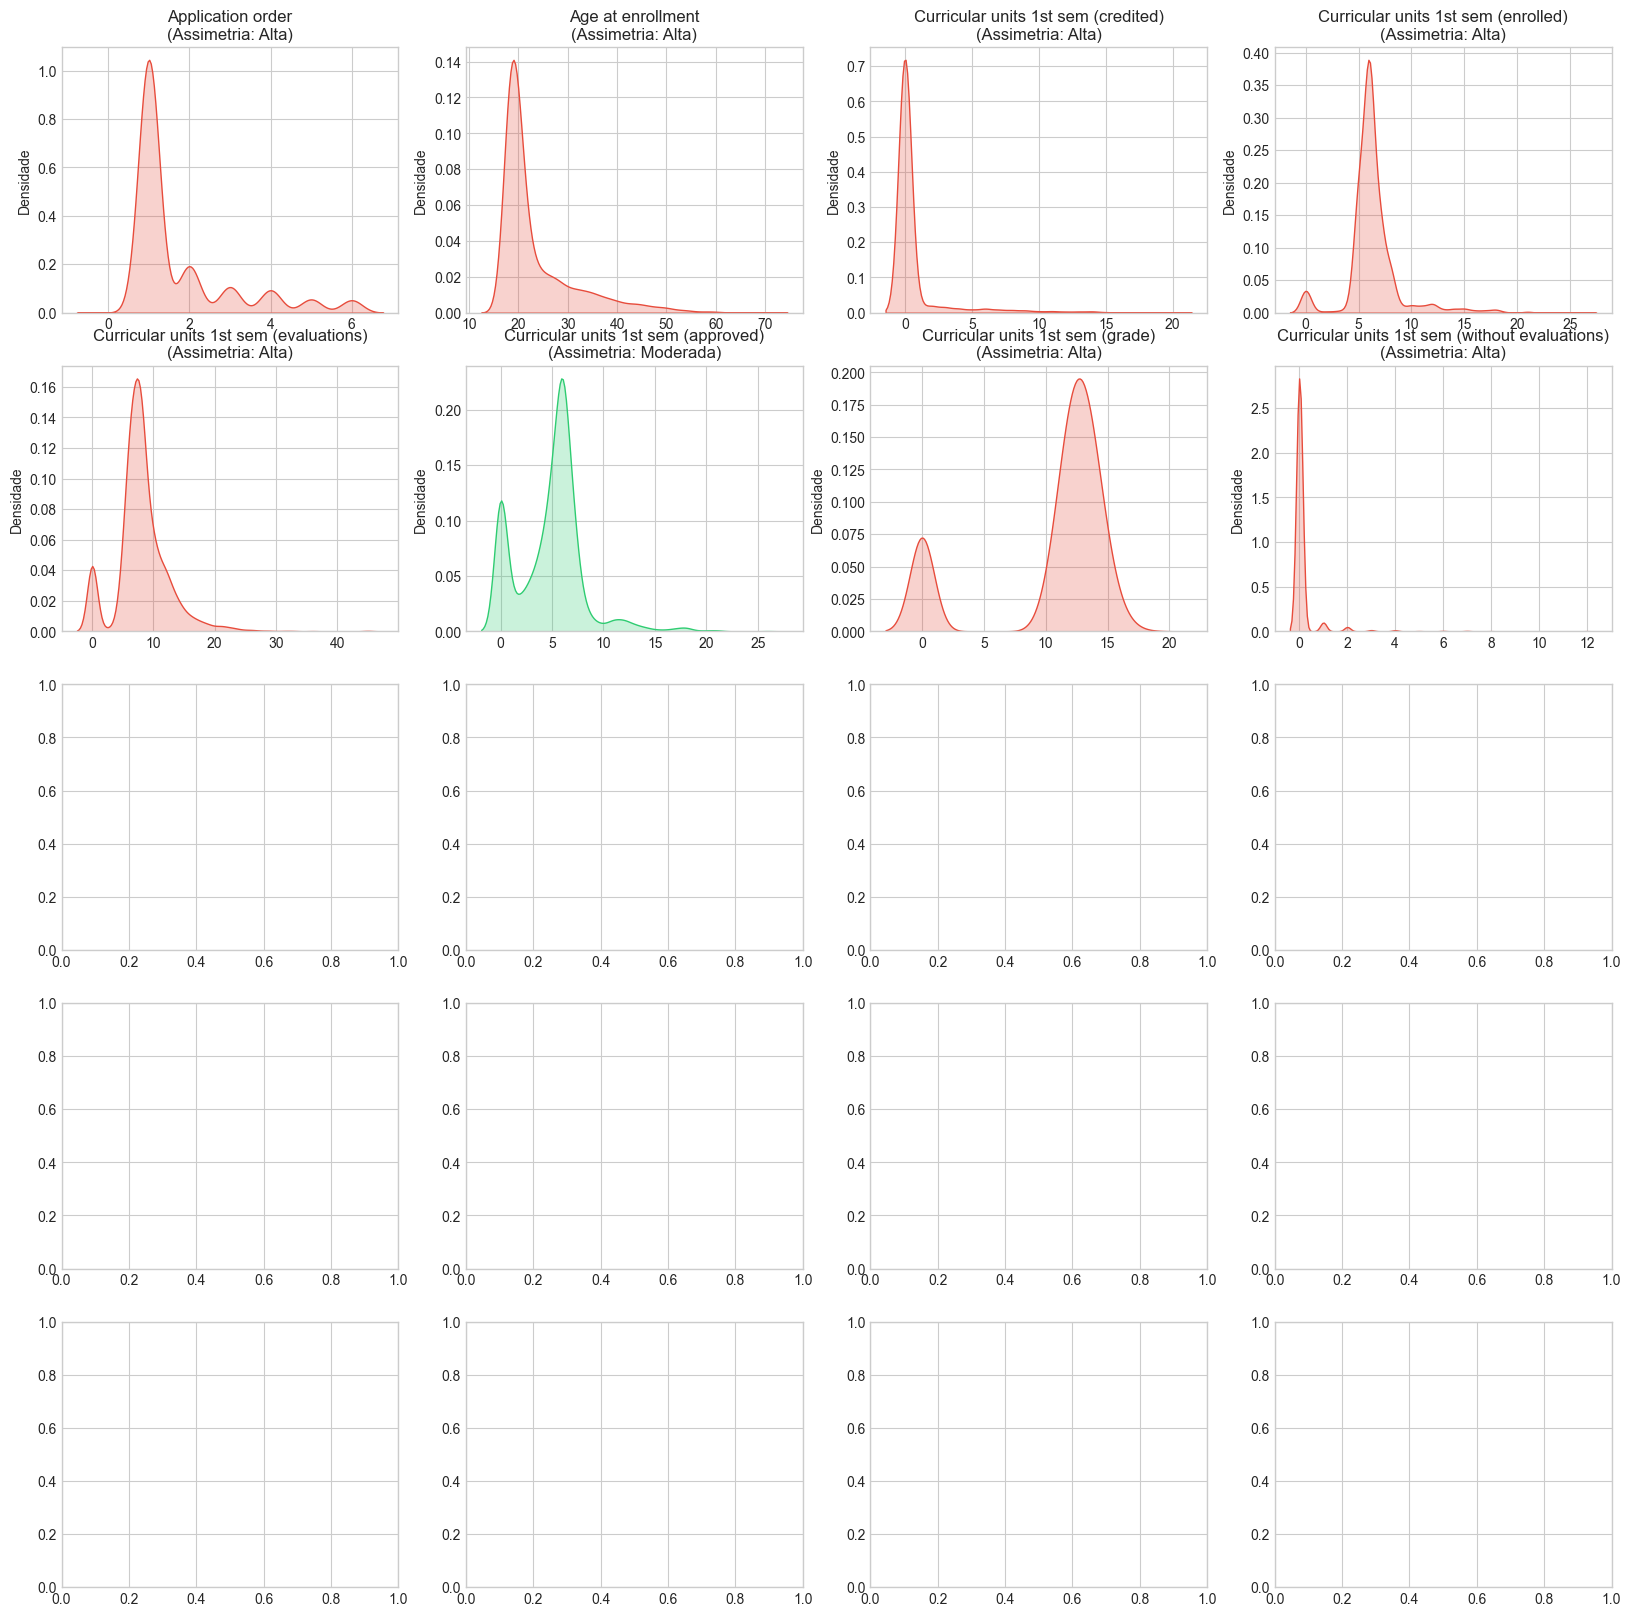

In [ ]:
numerical_features = df.select_dtypes(include=np.number)

skewness = numerical_features.skew()
skew_df = pd.DataFrame(skewness, columns=['Skewness']) 

skew_df['Tipo de Assimetria'] = skew_df['Skewness'].apply(
    lambda x: 'Alta' if abs(x) > 1 else 'Moderada' if abs(x) >= 0.5 else 'Aceit√°vel'
)

color_map = {
    'Alta': '#E74C3C',
    'Moderada': '#2ECC71',
    'Aceit√°vel': '#3498DB'
}

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

print("\n--- Gr√°ficos de Densidade de Kernel (KDE) ---")
for i, col in enumerate(numerical_features.columns):
    tipo_assimetria = skew_df.loc[col, 'Tipo de Assimetria']
    plot_color = color_map[tipo_assimetria]

    sns.kdeplot(ax=axes[i], data=df, x=col, fill=True, color=plot_color)
    
    axes[i].set_title(f'{col}\n(Assimetria: {tipo_assimetria})', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Densidade')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

skew_df_sorted = skew_df.sort_values(by='Skewness', key=abs, ascending=False)
display(skew_df_sorted)

- As vari√°veis com a maior assimetria positiva, de longe, s√£o `Curricular units (without evaluations)` e `Curricular units (credited)`. Isso indica um comportamento de "tudo ou nada". A grande maioria dos alunos tem um valor de zero para essas vari√°veis (ou seja, participam de todas as avalia√ß√µes e n√£o t√™m cr√©ditos anteriores para validar). No entanto, uma pequena minoria de alunos se desvia desse padr√£o (n√£o comparece a avalia√ß√µes ou vem de transfer√™ncias com muitos cr√©ditos), criando uma "cauda" longa e positiva na distribui√ß√£o. Essas n√£o s√£o apenas vari√°veis, s√£o fortes indicadores de perfis de alunos distintos: o aluno desengajado e o aluno transferido.

- As √∫nicas vari√°veis com assimetria negativa significativa s√£o as notas (grade) do 1¬∫ e 2¬∫ semestres. Isso √© causado por um "efeito teto". A escala de notas tem um valor m√°ximo (ex: 20). A maioria dos alunos que permanecem no curso e s√£o aprovados tende a ter um bom desempenho, com as notas se concentrando na parte superior da escala. Um n√∫mero menor de alunos tem um desempenho muito ruim, o que "puxa" a cauda da distribui√ß√£o para a esquerda (em dire√ß√£o √† nota zero). Isso sugere que notas muito baixas s√£o a exce√ß√£o, n√£o a regra.

Para as vari√°veis com assimetria Alta (tanto positiva quanto negativa), √© altamente recomend√°vel aplicar uma transforma√ß√£o (como a logar√≠tmica, `np.log1p`) antes de treinar modelos sens√≠veis √† escala, como Regress√£o Log√≠stica, SVM, Naive Bayes ou Redes Neurais. Isso ajuda o modelo a funcionar melhor.



--- Detec√ß√£o Visual de Outliers ---


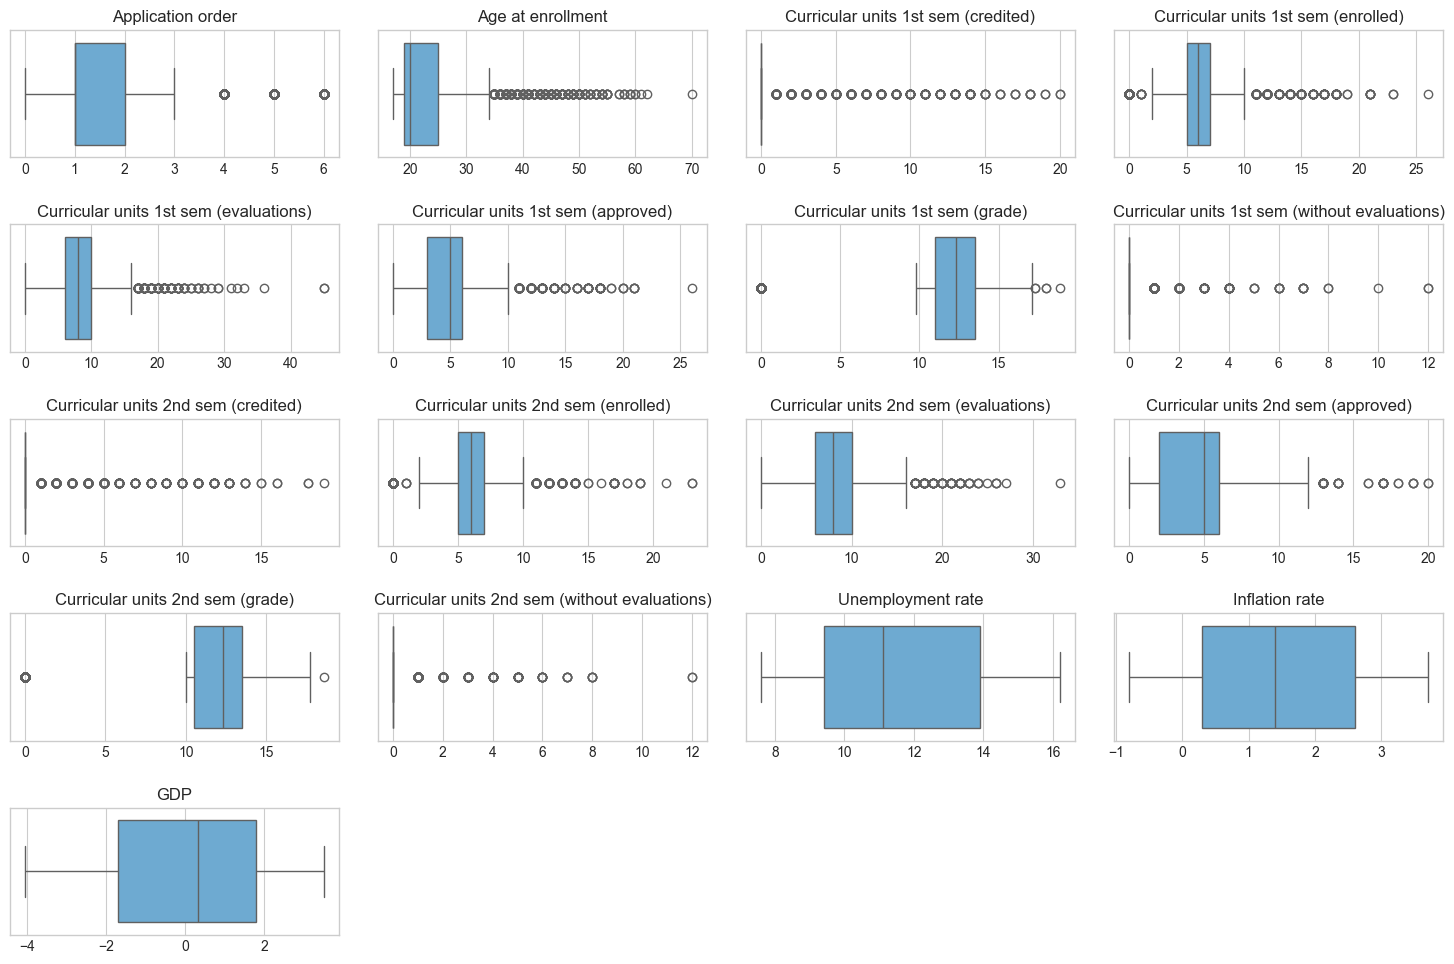

In [ ]:
print("\n\n--- Detec√ß√£o Visual de Outliers ---")

n_features = len(numerical_features.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2))
axes = axes.flatten()
    
for i, col in enumerate(numerical_features.columns):
    sns.boxplot(ax=axes[i], x=numerical_features[col], color='#5DADE2')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

- **Age at enrollment (Idade de Ingresso)**: O box plot mostra claramente uma concentra√ß√£o de alunos na faixa et√°ria tradicional (18-22 anos). Os in√∫meros pontos de outlier √† direita, indo at√© os 70 anos, s√£o os alunos maduros ("mature students"). Eles s√£o um grupo demogr√°fico distinto e fundamental para a an√°lise, n√£o um erro.

- **Curricular units ... (credited) (Unidades Creditadas)**: O "box" est√° achatado no zero, o que significa que a maioria dos alunos n√£o valida nenhuma mat√©ria. Todos os pontos de outlier s√£o, na verdade, os alunos transferidos ou com qualifica√ß√µes anteriores.

- **Curricular units ... (without evaluations) (Unidades sem Avalia√ß√£o)**: Este √© talvez o insight mais cr√≠tico. O box tamb√©m est√° achatado no zero, indicando que o comportamento normal √© participar de todas as avalia√ß√µes. Os outliers, portanto, s√£o os alunos desengajados. Cada ponto aqui √© um forte sinal de alerta de evas√£o.

- **Curricular units ... (grade) (Notas)**: Os outliers aqui est√£o principalmente na extremidade inferior. Enquanto a maioria dos alunos se concentra em notas mais altas (o "box"), os outliers de nota baixa representam os alunos com grande dificuldade acad√™mica, que s√£o os mais propensos a evadir.

- **Curricular units ... (approved) (Unidades Aprovadas)**: Os outliers na extremidade superior representam os alunos de alt√≠ssimo desempenho, que conseguem ser aprovados em um n√∫mero de mat√©rias bem acima da m√©dia.

- **Dados Macroecon√¥micos (Unemployment rate, Inflation rate, GDP)**: Como esperado, essas vari√°veis mostram distribui√ß√µes muito mais sim√©tricas e com poucos ou nenhum outlier. Isso ocorre porque s√£o dados agregados de uma economia, n√£o refletindo comportamentos individuais extremos.

##### Conclus√£o

N√£o deve ser removido nenhum outlier. Remover esses pontos significaria apagar a informa√ß√£o sobre os perfis mais importantes para um modelo preditivo: os alunos maduros, os transferidos, os desengajados e os com desempenho muito baixo. Isso prejudicaria drasticamente a capacidade do modelo de prever a evas√£o.

In [ ]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

# Feature Engineering

A etapa de Engenharia de Features √© onde os insights da nossa an√°lise explorat√≥ria e estat√≠stica √© usada para transformar os dados brutos em "sinais" muito mais claros e enriquecidos para o um modelo preditivo. Quanto melhor q qualidade das features, melhor o modelo.

Modelos matem√°ticos n√£o entendem texto solto (como 'Dropout' ou 'Graduate'). √â preciso convert√™-los em n√∫meros, e a melhor abordagem depende da natureza de cada vari√°vel. Por isso, usamos uma estrat√©gia h√≠brida baseada na cardinalidade (o n√∫mero de categorias √∫nicas):

| Caracter√≠stica         | One-Hot Encoding (`OneHotEncoder`)                                                                            | Target Encoding (`TargetEncoder`)                                                                                             |
|:-----------------------|:--------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------|
| **O que faz?** | Cria uma nova coluna bin√°ria (0 ou 1) para **cada categoria** da vari√°vel original.                               | Substitui cada categoria por um **√∫nico n√∫mero**: a m√©dia do alvo (`Target`) para aquela categoria.                             |
| **Quando Usar?** | Vari√°veis com **baixa cardinalidade** (poucas categorias √∫nicas, ex: 2 a 5). <br> *Ex: `Gender`, `Displaced`.* | Vari√°veis com **alta cardinalidade** (muitas categorias √∫nicas, ex: 6 ou mais). <br> *Ex: `Course`, `Mother's occupation`.* |
| **Vantagem Principal** | Representa√ß√£o completa e "honesta" dos dados, sem assumir rela√ß√µes de ordem ou valor entre as categorias.       | Extremamente eficiente. Captura o poder preditivo em uma √∫nica coluna, evitando a "maldi√ß√£o da dimensionalidade".            |
| **Desvantagem Principal**| Invi√°vel para alta cardinalidade (cria colunas demais, ex: 30 cursos -> 29 novas colunas).                     | Maior risco de overfitting. Requer t√©cnicas cuidadosas (como a valida√ß√£o cruzada) para ser robusto.   |
| **Exemplo Pr√°tico** | A coluna `Gender` com valores 'Male' e 'Female' se transforma na coluna `Gender_Male` com valores 0 ou 1.     | A categoria `'Enfermagem'` na coluna `Course` √© substitu√≠da pelo valor `0.18` (se a taxa de evas√£o em Enfermagem for 18%). |

In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_weak_features=True, rare_threshold=0.01):
        self.drop_weak_features = drop_weak_features
        self.rare_threshold = rare_threshold

    def fit(self, X, y):
        if not isinstance(y, pd.Series):
            y = pd.Series(y, name='Target')
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not is_numeric_dtype(y) or y.dtype.name == 'category':
            if y.unique().tolist() == ['Graduate', 'Dropout'] or 'Dropout' in y.unique().tolist():
                y = y.apply(lambda x: 1 if x == 'Dropout' else 0).rename('Target')
            else:
                y = pd.to_numeric(y, errors='coerce').fillna(0).astype(int) 

        self.course_grade_map_1sem_ = X.groupby('Course', observed=False)['Curricular units 1st sem (grade)'].mean()
        self.course_grade_map_2sem_ = X.groupby('Course', observed=False)['Curricular units 2nd sem (grade)'].mean()
        self.global_grade_mean_1sem_ = X['Curricular units 1st sem (grade)'].mean()
        self.global_grade_mean_2sem_ = X['Curricular units 2nd sem (grade)'].mean()

        original_categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.ohe_cols_ = [col for col in original_categorical_cols if X[col].nunique() <= 5]
        self.target_cols_ = [col for col in original_categorical_cols if X[col].nunique() > 5]
        
        self.target_cols_.append('interacao_curso_genero')
        self.ohe_cols_.append('faixa_etaria')

        # L√≥gica para aprender quais categorias s√£o raras em TODAS as colunas categ√≥ricas originais
        self.rare_maps_ = {}
        # As qualifica√ß√µes dos pais s√£o tratadas numericamente, ent√£o as exclu√≠mos deste passo.
        cols_to_check_for_rares = [col for col in original_categorical_cols if col not in ["Mother's qualification", "Father's qualification"]]
        for col in cols_to_check_for_rares:
            counts = X[col].value_counts(normalize=True)
            rare_cats = counts[counts < self.rare_threshold].index.tolist()
            if rare_cats:
                self.rare_maps_[col] = rare_cats

        X_temp_for_fit = X.copy()
        for col, rare_list in self.rare_maps_.items():
            X_temp_for_fit[col] = X_temp_for_fit[col].astype(str).replace(rare_list, 'Other')
        
        X_temp_for_fit['interacao_curso_genero'] = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
        X_temp_for_fit['faixa_etaria'] = pd.cut(X_temp_for_fit['Age at enrollment'], bins=[0, 20, 25, 40, 100], labels=['Tradicional_Jovem', 'Tradicional_Adulto', 'Maduro', 'Maduro_Senior'], right=False)

        for col in self.target_cols_ + self.ohe_cols_:
             if col in X_temp_for_fit.columns:
                X_temp_for_fit[col] = X_temp_for_fit[col].astype(str)
        
        self.target_maps_ = {}
        self.global_mean_ = y.mean()
        for col in self.target_cols_:
            if col == 'interacao_curso_genero':
                interaction_series = X_temp_for_fit['Course'].astype(str) + '_' + X_temp_for_fit['Gender'].astype(str)
                self.target_maps_[col] = pd.concat([interaction_series.rename(col), y], axis=1).groupby(col, observed=False)[y.name].mean()
            else:
                self.target_maps_[col] = pd.concat([X_temp_for_fit[col], y], axis=1).groupby(col, observed=False)[y.name].mean()
        
        self.target_encoder_ = TargetEncoder(target_type='binary')
        self.target_encoder_.fit(X_temp_for_fit[self.target_cols_], y)

        self.ohe_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
        self.ohe_.fit(X_temp_for_fit[self.ohe_cols_])
        
        return self

    def transform(self, X):
        X_transformed = X.copy()

        X_transformed['nivel_educacional_pais'] = (X_transformed["Mother's qualification"].astype(int) + X_transformed["Father's qualification"].astype(int))
        X_transformed['indice_estresse_financeiro'] = (X_transformed['Debtor'].astype(int) - X_transformed['Scholarship holder'].astype(int) + (1 - X_transformed['Tuition fees up to date'].astype(int)))

        for col, rare_list in self.rare_maps_.items():
            X_transformed[col] = X_transformed[col].astype(str).replace(rare_list, 'Other')

        X_transformed['interacao_curso_genero'] = X_transformed['Course'].astype(str) + '_' + X_transformed['Gender'].astype(str)
        X_transformed['faixa_etaria'] = pd.cut(X_transformed['Age at enrollment'], bins=[0, 20, 25, 40, 100], labels=['Tradicional_Jovem', 'Tradicional_Adulto', 'Maduro', 'Maduro_Senior'], right=False).astype(str)
        
        if hasattr(self, 'course_grade_map_1sem_'):
            avg_grade_1sem = X_transformed['Course'].astype(str).map(self.course_grade_map_1sem_).fillna(self.global_grade_mean_1sem_)
            X_transformed['desvio_nota_1sem'] = X_transformed['Curricular units 1st sem (grade)'] - avg_grade_1sem
            avg_grade_2sem = X_transformed['Course'].astype(str).map(self.course_grade_map_2sem_).fillna(self.global_grade_mean_2sem_)
            X_transformed['desvio_nota_2sem'] = X_transformed['Curricular units 2nd sem (grade)'] - avg_grade_2sem

        taxa_1 = X_transformed['Curricular units 1st sem (approved)'] / X_transformed['Curricular units 1st sem (enrolled)']
        X_transformed['taxa_aprovacao_1sem'] = taxa_1.replace([np.inf, -np.inf], 0).fillna(0)
        taxa_2 = X_transformed['Curricular units 2nd sem (approved)'] / X_transformed['Curricular units 2nd sem (enrolled)']
        X_transformed['taxa_aprovacao_2sem'] = taxa_2.replace([np.inf, -np.inf], 0).fillna(0)
        
        X_transformed['progresso_academico'] = X_transformed['taxa_aprovacao_2sem'] - X_transformed['taxa_aprovacao_1sem']
        total_without_evals = X_transformed['Curricular units 1st sem (without evaluations)'] + X_transformed['Curricular units 2nd sem (without evaluations)']
        X_transformed['aluno_desengajado'] = (total_without_evals > 0).astype(int)

        for col in self.target_cols_ + self.ohe_cols_:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].astype(str)
                
        target_encoded_data = self.target_encoder_.transform(X_transformed[self.target_cols_])
        target_encoded_df = pd.DataFrame(target_encoded_data, index=X_transformed.index, columns=[f"{c}_encoded" for c in self.target_cols_])

        ohe_data = self.ohe_.transform(X_transformed[self.ohe_cols_])
        ohe_df = pd.DataFrame(ohe_data, index=X_transformed.index, columns=self.ohe_.get_feature_names_out(self.ohe_cols_))
        
        X_final = X_transformed
        X_final = pd.concat([X_final, target_encoded_df, ohe_df], axis=1)

        cols_to_drop = [
            # Categ√≥ricas substitu√≠das por encoders
            'Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 
            'Previous qualification', 'Nacionality', "Mother's occupation", 
            "Father's occupation", 'Displaced', 'Educational special needs', 'Gender', 'International',
            # Num√©ricas substitu√≠das por features de engenharia
            'Curricular units 1st sem (approved)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (grade)',
            'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (grade)',
            'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)',
            'Debtor', 'Tuition fees up to date', 'Scholarship holder', 
            "Mother's qualification", "Father's qualification", 'Age at enrollment'
        ]
        
        X_final = X_final.drop(columns=cols_to_drop, errors='ignore')
        X_final = X_final.drop(columns=['interacao_curso_genero', 'faixa_etaria'], errors='ignore')

        if self.drop_weak_features:
            weak_features = [col for col in X_final.columns if 'International' in col or 'Educational special needs' in col]
            X_final = X_final.drop(columns=weak_features, errors='ignore')
            
        return X_final

O resultado √© um dataset completamente num√©rico e enriquecido, pronto para ser utilizado pelos algoritmos de Machine Learning.

Features Codificadas:
- As colunas terminadas em `_encoded` (ex: `Course_encoded`) cont√™m os valores do Target Encoding. Cada valor representa a taxa m√©dia de evas√£o associada √† categoria original, medindo efetivamente o "risco" de cada uma.
- As colunas terminadas com o nome da categoria (ex: `faixa_etaria_Maduro`) s√£o o resultado do One-Hot Encoding. Elas s√£o "flags" bin√°rias (0 ou 1) que indicam a presen√ßa ou aus√™ncia de uma determinada caracter√≠stica.


Features Originais Mantidas: Vari√°veis num√©ricas que n√£o apresentaram alta multicolinearidade e n√£o foram substitu√≠das por features de engenharia (como Application order e os indicadores macroecon√¥micos) foram mantidas em sua forma original.

- **Para Reduzir Multicolinearidade (Insight do VIF e Correla√ß√£o)**: Vimos que as `Curricular units ...` eram altamente correlacionadas. Em vez de us√°-las diretamente, criamos taxas como `taxa_aprovacao_ ...` (aprovadas / matriculadas), que s√£o mais informativas e resolvem a redund√¢ncia.

- **Para Capturar Comportamentos (Insight da Assimetria e Outliers)**: A an√°lise mostrou que `Curricular units (without evaluations)` indicava um comportamento de "tudo ou nada". A feature `aluno_desengajado` transforma essa observa√ß√£o estat√≠stica em uma "flag" de risco clara e direta para o modelo.

- **Para Combinar Preditores Fortes (Insight do Qui-Quadrado e ANOVA)**: Nossa an√°lise mostrou que `Debtor`, `Tuition fees up to date` e `Scholarship holder` eram os preditores mais fortes. A feature `indice_estresse_financeiro` os combina em um √∫nico e poderoso indicador da situa√ß√£o do aluno.

√â importante notar que todo o "aprendizado" necess√°rio para as transforma√ß√µes (como as m√©dias para o Target Encoding e as categorias para o One-Hot Encoding) devem ser feitos apenas com os dados de treino e teste de forma separada. Isso garante que n√£o haja vazamento de dados (data leakage).

In [ ]:
class ReflectionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_values_ = None

    def fit(self, X, y=None):
        # Aprende o valor m√°ximo de cada coluna nos dados de treino
        self.max_values_ = X.max()
        return self

    def transform(self, X):
        # Aplica a f√≥rmula de reflex√£o: (max + 1) - valor
        return (self.max_values_ + 1) - X

In [ ]:
class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    """
    Esta classe recebe um dataframe com features j√° criadas, analisa suas
    distribui√ß√µes (assimetria) e aplica o pr√©-processamento correto
    (log, reflex√£o, escalonamento) a cada subconjunto de colunas.
    """
    def __init__(self, positive_skew_threshold=1.0, negative_skew_threshold=-1.0):
        self.positive_skew_threshold = positive_skew_threshold
        self.negative_skew_threshold = negative_skew_threshold

    def fit(self, X, y=None):
        skewness = X.skew(numeric_only=False)
        
        self.positive_skew_features_ = skewness[skewness > self.positive_skew_threshold].index.tolist()
        self.negative_skew_features_ = skewness[skewness < self.negative_skew_threshold].index.tolist()
        
        all_numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        ohe_cols = [col for col in X.columns if '_' in col and X[col].nunique() <= 2]
        passthrough_features = ohe_cols + [col for col in X.columns if 'aluno_desengajado' in col]

        self.numeric_no_skew_features_ = [
            col for col in all_numeric_cols 
            if col not in self.positive_skew_features_ and col not in self.negative_skew_features_ and col not in passthrough_features
        ]

        self.preprocessor_ = ColumnTransformer(
            transformers=[
                ('pos_skew', SklearnPipeline(
                    steps=[
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.positive_skew_features_),
                ('neg_skew', SklearnPipeline(
                    steps=[
                        ('reflect', ReflectionTransformer()), 
                        ('log', FunctionTransformer(np.log1p)), 
                        ('scaler', StandardScaler())
                    ]
                ), self.negative_skew_features_),
                ('no_skew', StandardScaler(), self.numeric_no_skew_features_)
            ],
            remainder='passthrough'
        )
        
        self.preprocessor_.fit(X)
        return self

    def transform(self, X):
        return self.preprocessor_.transform(X)

# Model Selection

In [ ]:
X = df.drop('Target', axis=1)
y = df['Target'].map({'Dropout': 1, 'Graduate': 0})
y.name = 'Target'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

In [ ]:
def compute_class_weights(y):
    class_counts = pd.Series(y).value_counts().sort_index()
    total = len(y)
    weights = total / (len(class_counts) * class_counts)
    return weights.tolist()

cv_probabilities_df = pd.DataFrame({'y_real': y_train.copy()})
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Grupo 1: Modelos que precisam de normaliza√ß√£o e tratamento de assimetria
# Usaremos ADASYN para balanceamento, pois class_weight n√£o est√° dispon√≠vel em todos (ex: GaussianNB)
models_sensitive_to_distribution = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # "Ridge Classifier": RidgeClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    # "Linear SVM": LinearSVC(random_state=42, dual='auto'), # dual='auto' para evitar warnings
    # "Passive Aggressive": PassiveAggressiveClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True, solver='adam', activation='relu'),
    "Gaussian Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
}

# Grupo 2: Modelos robustos (baseados em √°rvore) que n√£o precisam de pr√©-processamento de escala/distribui√ß√£o
# Usaremos class_weight='balanced' ou scale_pos_weight, que s√£o eficientes para eles
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
models_robust_to_distribution = {
    "Decision Tree": DecisionTreeClassifier(class_weight=None, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight=None, random_state=42),
    "Extra Trees": ExtraTreesClassifier(class_weight=None, random_state=42),
    "HistGBM": HistGradientBoostingClassifier(class_weight=None, random_state=42),
    "LightGBM": LGBMClassifier(class_weight=None, random_state=42, verbosity=-1),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=500, class_weights={0:1, 1:scale_pos_weight}, verbose=0, random_state=42),
}

# --- ETAPA 2: AVALIA√á√ÉO DOS MODELOS ---

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_recall_scores = {}

# 2a. Loop para modelos sens√≠veis com pipeline de pr√©-processamento completo
print(">>> AVALIANDO MODELOS SENS√çVEIS √Ä DISTRIBUI√á√ÉO (COM LOG TRANSFORM) <<<")
for name, model in models_sensitive_to_distribution.items():
    # Pipeline completo com engenharia, pr√©-processamento din√¢mico e reamostragem
    sensitive_pipe = ImblearnPipeline(steps=[
        ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
        ('dynamic_preprocessor', DynamicPreprocessor()),
        ('resampling', ADASYN(random_state=42)),
        ('classifier', model)
    ])
    
    probabilities = cross_val_predict(sensitive_pipe, X_train, y_train, cv=cv_strategy, method='predict_proba')
    cv_probabilities_df[name] = probabilities[:, 1]
    
    print(f"Processando: {name}...")
    recall = cross_val_score(sensitive_pipe, X_train, y_train, cv=cv_strategy, scoring='recall')
    final_recall_scores[name] = (np.mean(recall), np.std(recall))

print("\n>>> AVALIANDO MODELOS ROBUSTOS (SEM LOG TRANSFORM) <<<")
for name, model in models_robust_to_distribution.items():
    simple_pipeline = ImblearnPipeline(steps=[
        ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
        ('scaler', StandardScaler()),
        ('resampling', ADASYN(random_state=42)),
        ('classifier', model)
    ])
    
    probabilities = cross_val_predict(simple_pipeline, X_train, y_train, cv=cv_strategy, method='predict_proba')
    cv_probabilities_df[name] = probabilities[:, 1]
    
    print(f"Processando: {name}...")
    recall = cross_val_score(simple_pipeline, X_train, y_train, cv=cv_strategy, scoring='recall')
    final_recall_scores[name] = (np.mean(recall), np.std(recall))

>>> AVALIANDO MODELOS SENS√çVEIS √Ä DISTRIBUI√á√ÉO (COM LOG TRANSFORM) <<<
Processando: Logistic Regression...
Processando: Support Vector Machine...
Processando: MLP Classifier...
Processando: Gaussian Naive Bayes...
Processando: KNN...
Processando: LDA...
Processando: QDA...

>>> AVALIANDO MODELOS ROBUSTOS (SEM LOG TRANSFORM) <<<
Processando: Decision Tree...
Processando: Random Forest...
Processando: Extra Trees...
Processando: HistGBM...
Processando: LightGBM...
Processando: XGBoost...
Processando: AdaBoost...
Processando: CatBoost...


In [ ]:
print("\n\n--- RESULTADOS FINAIS DA VALIDA√á√ÉO CRUZADA ---")
results_df = pd.DataFrame.from_dict(final_recall_scores, orient='index', columns=['Recall_Medio', 'Desvio_Padrao'])
results_df = results_df.sort_values(by='Recall_Medio', ascending=False)

display(results_df.style.background_gradient(cmap='viridis'))



--- RESULTADOS FINAIS DA VALIDA√á√ÉO CRUZADA ---


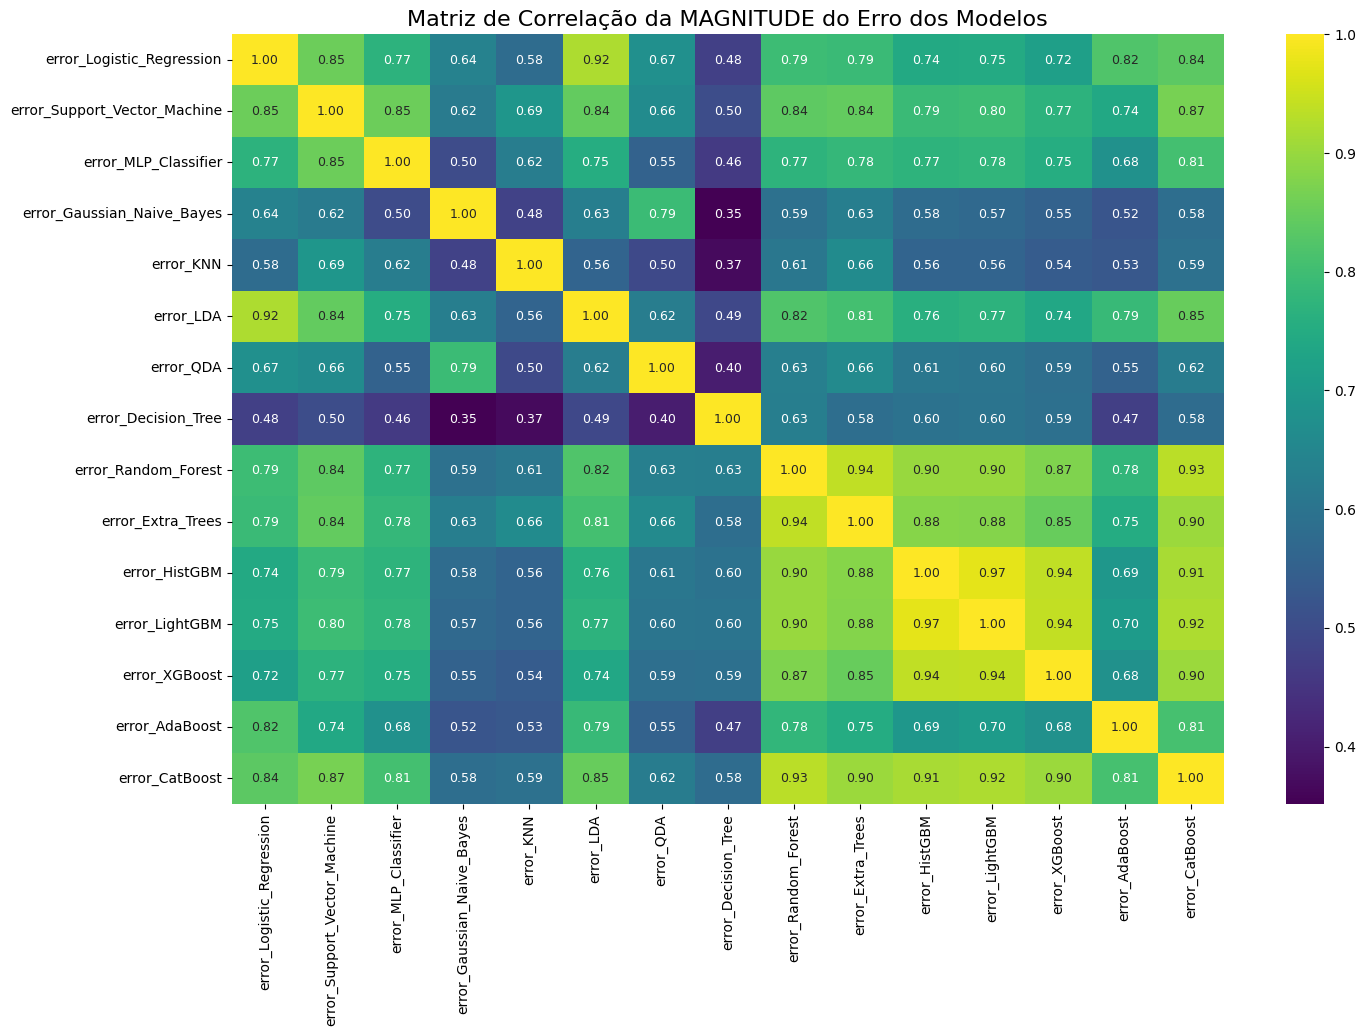

In [ ]:
error_magnitude_df = pd.DataFrame()
all_model_names = list(models_sensitive_to_distribution.keys()) + list(models_robust_to_distribution.keys())
y_real_numeric = cv_probabilities_df['y_real'].astype(int)

for name in all_model_names:
    error_col_name = f"error_{name.replace(' ', '_')}"
    error_magnitude_df[error_col_name] = np.abs(cv_probabilities_df[name] - y_real_numeric)

error_correlation = error_magnitude_df.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(error_correlation, annot=True, cmap='viridis', fmt=".2f", annot_kws={"size": 9})
plt.title('Matriz de Correla√ß√£o da MAGNITUDE do Erro dos Modelos', fontsize=16)
plt.show()

In [ ]:
pipeline_ada = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer(drop_weak_features=True)),
    ('scaler', StandardScaler()),
    # ('dynamic_preprocessor', DynamicPreprocessor()),
    ('resampling', ADASYN(random_state=42)),
    ('classifier', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42))
])

pipeline_qda = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    # ('scaler', StandardScaler()),
    ('dynamic_preprocessor', DynamicPreprocessor()),
    ('resampling', ADASYN(random_state=42)),
    # ('classifier', CatBoostClassifier(iterations=500, class_weights={0:1, 1:scale_pos_weight}, verbose=0, random_state=42))
    ('classifier', SVC(probability=True, random_state=42))
])

pipeline_log = ImblearnPipeline(steps=[
    ('feature_engineering', FeatureEngineer(drop_weak_features=True)),
    # ('scaler', StandardScaler()),
    ('dynamic_preprocessor', DynamicPreprocessor()),
    ('resampling', ADASYN(random_state=42)),
    # ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ("MLP Classifier", MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True, solver='adam', activation='relu'))
])

estimators = [
    ('adaboost', pipeline_ada),
    ('qda', pipeline_qda),
    ('logistic', pipeline_log)
]

meta_classifier = LogisticRegression(random_state=42, max_iter=1000)

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=cv_strategy,
    passthrough=False
)

scores = cross_val_score(stacking_model, X_train, y_train, cv=cv_strategy, scoring='recall')

print(f"Recall M√©dio (CV=5): {np.mean(scores):.4f}")  
print(f"Desvio Padr√£o dos Scores: {np.std(scores):.4f}")
print("---"*20)
print(f"Recall M√©dio do melhor modelo individualmente (AdaBoost) (CV=5): {results_df['Recall_Medio'][0]:.4f}")  
print(f"Desvio Padr√£o dos Scores do melhor modelo individualmente (AdaBoost): {results_df['Desvio_Padrao'][0]:.4f}")

Recall M√©dio (CV=5): 0.8645
Desvio Padr√£o dos Scores: 0.0226
------------------------------------------------------------
Recall M√©dio do melhor modelo individualmente (AdaBoost) (CV=5): 0.8795
Desvio Padr√£o dos Scores do melhor modelo individualmente (AdaBoost): 0.0271


**CONCLUS√ÉO**: N√£o vale a pena fazer o modelo de Stacking

## Tunagem de Hyperparametros

In [ ]:
if os.path.exists('./best_adaboost.pkl'):
    best_adaboost_pipeline = joblib.load('best_adaboost.pkl')
else:
    base_estimator = DecisionTreeClassifier(class_weight='balanced', random_state=42)

    ada_model = AdaBoostClassifier(estimator=base_estimator, random_state=42)

    search_space_adaboost = {
        'classifier__n_estimators': Integer(50, 1000),
        'classifier__learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'classifier__estimator__max_depth': Integer(1, 5) # Profundidade da √°rvore base
    }

    full_pipeline_ada = ImblearnPipeline(steps=[
        ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
        ('scaler', StandardScaler()),
        ('resampling', ADASYN(random_state=42)),
        ('classifier', ada_model)
    ])

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Configura√ß√£o da Busca Bayesiana focada em RECALL
    optimizer_ada = BayesSearchCV(
        estimator=full_pipeline_ada,
        search_spaces=search_space_adaboost,
        n_iter=96,
        cv=cv_strategy,
        scoring='recall',
        random_state=42,
        verbose=0
    )

    optimizer_ada.fit(X_train, y_train)
    best_adaboost_pipeline = optimizer_ada.best_estimator_

    print(f"Melhor Recall (cross-val): {optimizer_ada.best_score_:.4f}")
    print("Melhores Hiperpar√¢metros encontrados:")
    for param, value in optimizer_ada.best_params_.items():
        print(f"  - {param}: {value}")

    joblib.dump(best_adaboost_pipeline, 'best_adaboost.pkl')

In [ ]:
set_config(display='diagram')

best_adaboost_pipeline

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=2,
                                                                     random_state=42),
                                    learning_rate=0.0432315460587612,
                                    n_estimators=861, random_state=42))])

### An√°lise de import√¢ncia do Modelo

In [ ]:
final_model_pipeline = best_adaboost_pipeline.fit(X_train, y_train)
feature_engineer_trained = final_model_pipeline.named_steps['feature_engineer']

X_train_enriched = feature_engineer_trained.transform(X_train)
classifier_trained = final_model_pipeline.named_steps['classifier']

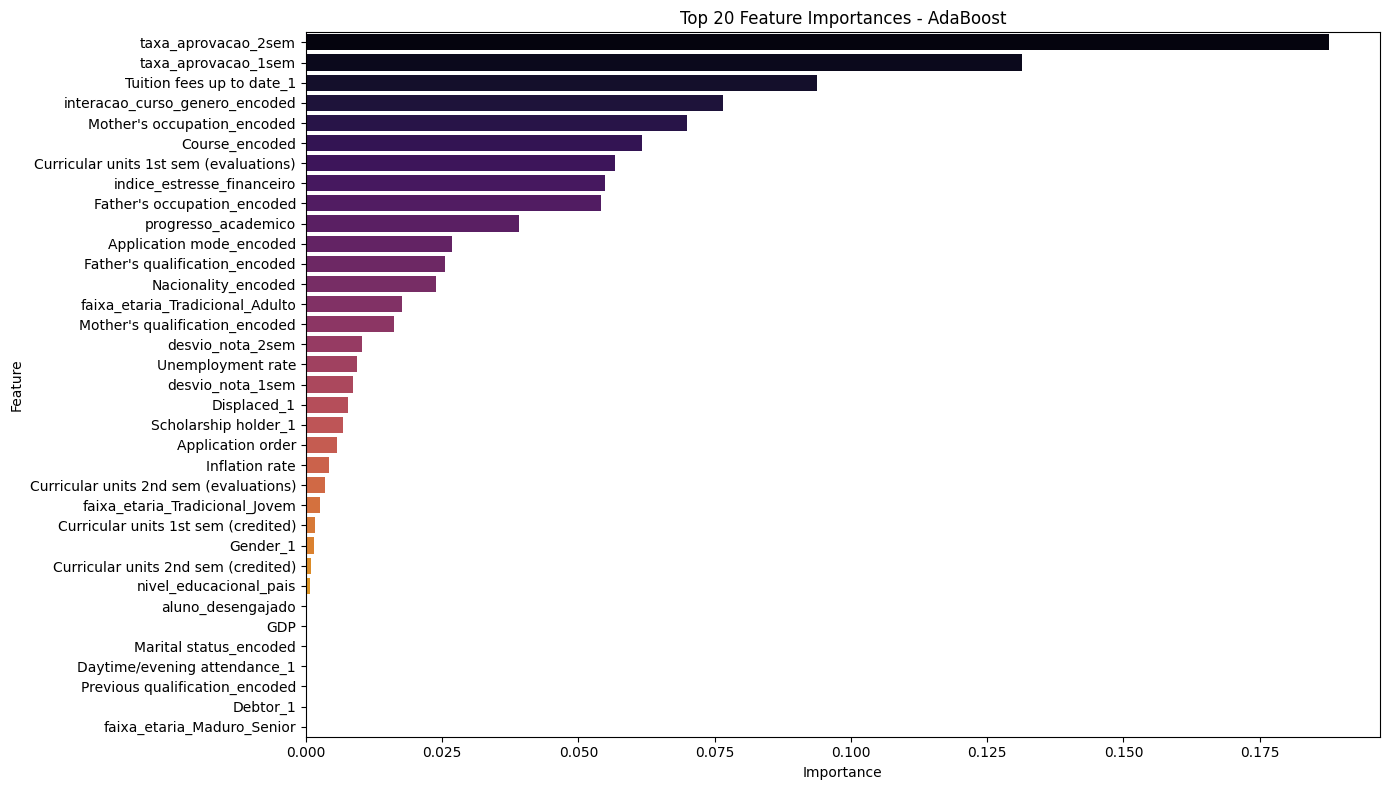

In [ ]:
model = best_adaboost_pipeline.named_steps['classifier']

# Usa diretamente as colunas do DataFrame
feature_names = X_train_enriched.columns
importances_gini = model.feature_importances_

# Monta o DataFrame de import√¢ncias
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_gini
}).sort_values(by='importance', ascending=False)

# Plota as top 20 features
plt.figure(figsize=(14, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='inferno')
plt.title('Top 20 Feature Importances - AdaBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

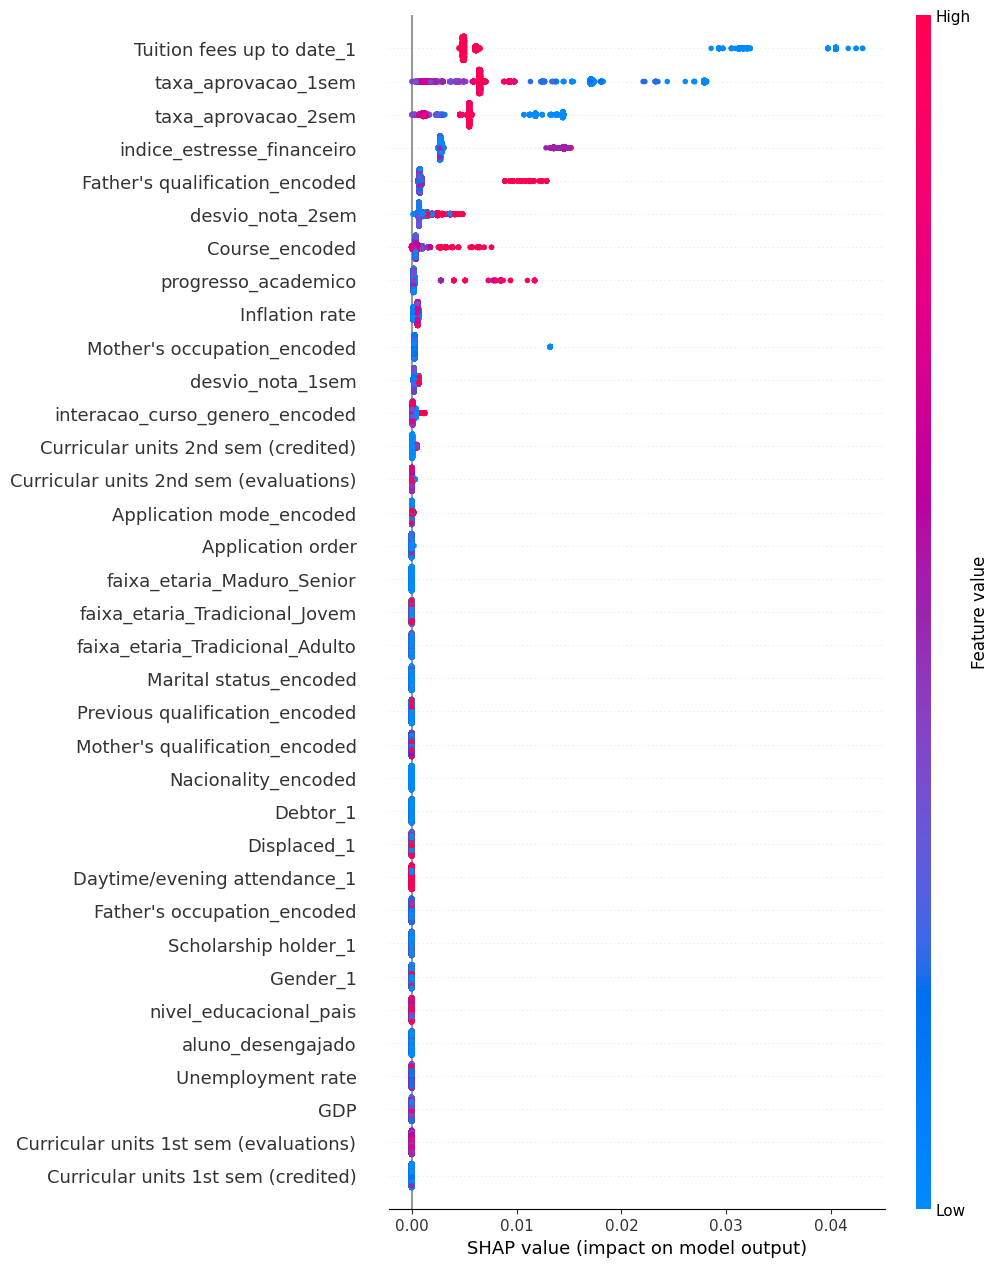

In [ ]:
shap.initjs()

explainer = shap.Explainer(classifier_trained, X_train_enriched)
shap_values = explainer(X_train_enriched)

shap.plots.beeswarm(shap_values[:, :, 1].abs, max_display=35)

In [ ]:
importance_shap = shap_values.abs.mean(axis=0).values.mean(axis=1) 
features_shap = X_train_enriched.columns[importance_shap > 0].tolist()
features_gini = feature_importance_df[feature_importance_df['importance'] > 0]['feature'].tolist()

gini_only_features = set(features_gini) - set(features_shap)

print(f"Total de features importantes para Gini: {len(features_gini)}")
print(f"Total de features importantes para SHAP: {len(features_shap)}")
print("-" * 50)
print(f"Features importantes APENAS para o Gini (candidatas √† remo√ß√£o):")
pprint(list(gini_only_features))

Total de features importantes para Gini: 28
Total de features importantes para SHAP: 16
--------------------------------------------------
Features importantes APENAS para o Gini (candidatas √† remo√ß√£o):
['Scholarship holder_1',
 'Nacionality_encoded',
 'faixa_etaria_Tradicional_Adulto',
 'nivel_educacional_pais',
 "Father's occupation_encoded",
 'faixa_etaria_Tradicional_Jovem',
 'Curricular units 1st sem (credited)',
 'Displaced_1',
 'Unemployment rate',
 'Curricular units 1st sem (evaluations)',
 "Mother's qualification_encoded",
 'Gender_1']


Comparando Gini vs. SHAP: Por que a Diferen√ßa?

- **Import√¢ncia Gini** (`.feature_importances_`): Mede a frequ√™ncia e a efic√°cia com que uma feature foi usada para criar "n√≥s" puros durante a constru√ß√£o das √°rvores de decis√£o. Ele pode dar um valor de import√¢ncia pequeno, mas n√£o-zero, a features que foram usadas em algum momento, mesmo que seu impacto final na previs√£o seja m√≠nimo.
- **Import√¢ncia SHAP** (M√©dia do Valor Absoluto): Mede o impacto real de uma feature na sa√≠da final do modelo. Se uma feature √© usada em uma √°rvore, mas seu efeito √© cancelado por outras √°rvores no ensemble, seu valor SHAP m√©dio pode ser zero.

**Conclus√£o-chave**: O SHAP √© considerado uma m√©trica mais confi√°vel e verdadeira da import√¢ncia preditiva de uma feature. O fato de ele ter identificado um conjunto menor (16 features) sugere que as outras 12 features, embora usadas na constru√ß√£o do modelo, t√™m um impacto l√≠quido negligenci√°vel ou nulo nas previs√µes finais.

In [ ]:
pipeline_shap = ImblearnPipeline(steps=[
    ('feature_engineer', FeatureEngineer(drop_weak_features=True)),
    ('feature_selector', ColumnTransformer(
        transformers=[
            ("selector", "passthrough", features_shap)
        ], 
        remainder='drop'
    )),
    ('scaler', StandardScaler()),
    ('resampling', ADASYN(random_state=42)),
    ('classifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            class_weight=classifier_trained.estimator.class_weight,
            max_depth=classifier_trained.estimator.max_depth,
            random_state=42
        ),
        learning_rate=classifier_trained.learning_rate,
        n_estimators=classifier_trained.n_estimators,
        random_state=42
    ))
])

# Faz predi√ß√µes por cross-validation
y_pred_shap = cross_val_predict(
    pipeline_shap,
    X_train,
    y_train,
    cv=cv_strategy
)

y_pred_default = cross_val_predict(
    best_adaboost_pipeline,
    X_train,
    y_train,
    cv=cv_strategy
)

# Gera o classification report
display(pd.DataFrame(classification_report(y_train, y_pred_shap, digits=3, output_dict=True)).T.rename(index={'0': 'graduate','1': 'dropout'}))
print('----'*20)
display(pd.DataFrame(classification_report(y_train, y_pred_default, digits=3, output_dict=True)).T.rename(index={'0': 'graduate','1': 'dropout'}))

precision    recall  f1-score      support
graduate       0.932618  0.885116  0.908246  1767.000000
dropout        0.834556  0.900616  0.866328  1137.000000
accuracy       0.891185  0.891185  0.891185     0.891185
macro avg      0.883587  0.892866  0.887287  2904.000000
weighted avg   0.894224  0.891185  0.891834  2904.000000

--------------------------------------------------------------------------------


precision    recall  f1-score      support
graduate       0.929287  0.892473  0.910508  1767.000000
dropout        0.842585  0.894459  0.867747  1137.000000
accuracy       0.893251  0.893251  0.893251     0.893251
macro avg      0.885936  0.893466  0.889128  2904.000000
weighted avg   0.895341  0.893251  0.893766  2904.000000

Foi poss√≠vel criar um modelo mais simples e eficiente (o `pipeline_shap`, que usa menos features) que:

1. Melhorou a m√©trica mais importante para o seu problema de neg√≥cio: o **Recall**. Ou seja, ele consegue identificar uma porcentagem ainda maior de alunos em risco.
2. Manteve um desempenho virtualmente id√™ntico em **F1-Score** e **Acur√°cia**. A diferen√ßa de 0.2% √© estatisticamente insignificante e est√° dentro da margem de varia√ß√£o da valida√ß√£o cruzada.

Em Machine Learning, existe um princ√≠pio fundamental conhecido como a **Navalha de Ockham**: dentre as hip√≥teses (ou modelos) com poder preditivo semelhante, a mais simples √© quase sempre a melhor.

Modelos mais simples s√£o prefer√≠veis porque s√£o:

- **Mais R√°pidos**: Exigem menos tempo para treinar e para fazer previs√µes.
- **Mais F√°ceis de Manter**: T√™m menos depend√™ncias de features de entrada, o que os torna mais robustos em um ambiente de produ√ß√£o.
- **Menos Propensos a Overfitting**: Ao remover features com baixo poder preditivo, reduzimos a chance de o modelo aprender "ru√≠do" nos dados de treino.

## Compara√ß√£o das M√©tricas Finais 


Gerando previs√µes de CV para as curvas de an√°lise...


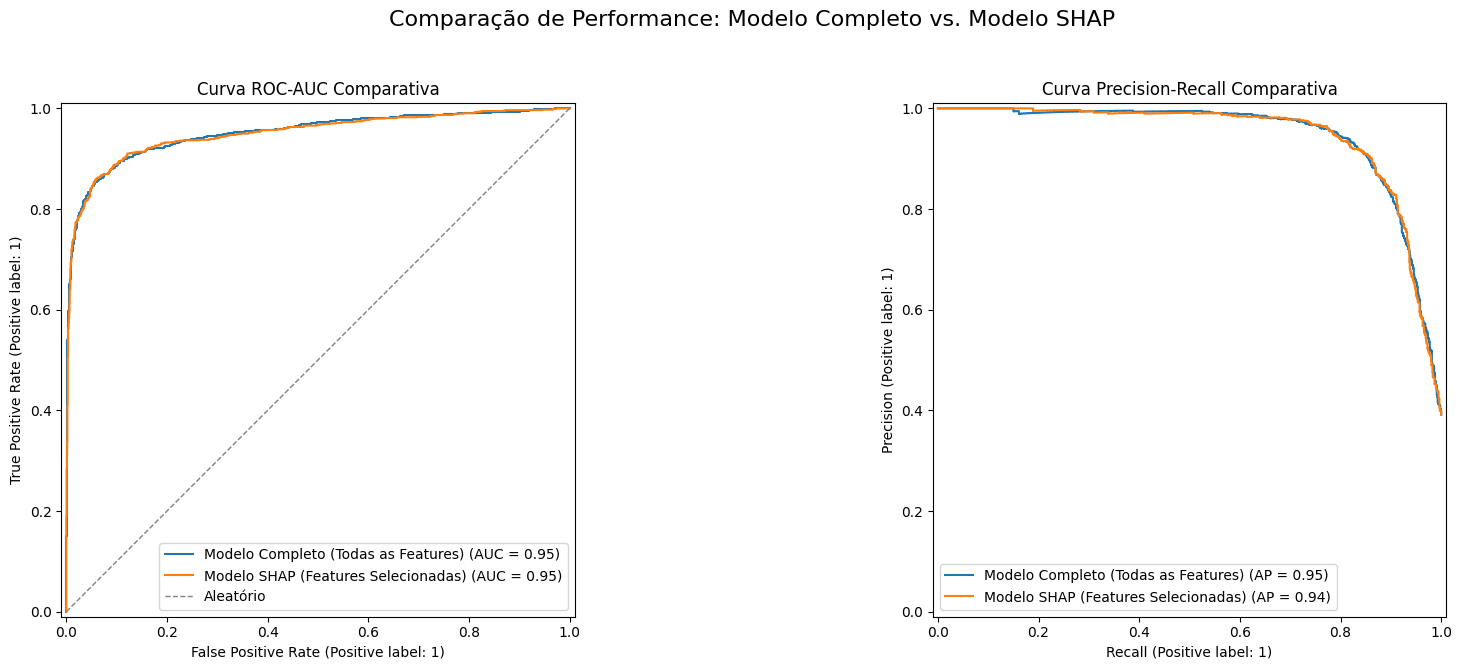

In [ ]:
print("\nGerando previs√µes de CV para as curvas de an√°lise...")
# Previs√µes para o modelo com features SHAP
y_probas_shap = cross_val_predict(
    pipeline_shap, 
    X_train, 
    y_train, 
    cv=cv_strategy, 
    method='predict_proba',
)

# Previs√µes para o modelo padr√£o (todas as features)
y_probas_default = cross_val_predict(
    best_adaboost_pipeline, 
    X_train, 
    y_train, 
    cv=cv_strategy, 
    method='predict_proba',
)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Compara√ß√£o de Performance: Modelo Completo vs. Modelo SHAP', fontsize=16)

RocCurveDisplay.from_predictions(
    y_train, 
    y_probas_default[:, 1], # Probabilidades da classe positiva
    ax=axes[0], 
    name="Modelo Completo (Todas as Features)"
)

RocCurveDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], 
    ax=axes[0], 
    name="Modelo SHAP (Features Selecionadas)"
)
axes[0].plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Aleat√≥rio')
axes[0].set_title("Curva ROC-AUC Comparativa")
axes[0].legend()

PrecisionRecallDisplay.from_predictions(
    y_train, 
    y_probas_default[:, 1], 
    ax=axes[1], 
    name="Modelo Completo (Todas as Features)"
)

PrecisionRecallDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], 
    ax=axes[1], 
    name="Modelo SHAP (Features Selecionadas)"
)
axes[1].set_title("Curva Precision-Recall Comparativa")
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- **Curva ROC-AUC (O Empate T√©cnico)**:
    - O AUC mede a capacidade geral do modelo de distinguir um aluno que vai evadir de um que vai se formar. Um resultado id√™ntico significa que o poder de discrimina√ß√£o fundamental dos dois modelos √© exatamente o mesmo. As 12 features extras que o modelo completo utiliza n√£o adicionam nenhum poder de separa√ß√£o geral entre as classes.

- **Curva Precision-Recall (A Vantagem Marginal)**:
    - √â aqui que vemos a √∫nica, e muito pequena, vantagem do modelo completo (AP = 0.95 vs 0.94). A √Årea sob a Curva Precision-Recall (AP) √© mais sens√≠vel em datasets desbalanceados. Essa diferen√ßa de 0.01 nos diz que o modelo completo, ao longo de todos os limiares de decis√£o, consegue manter uma precis√£o ligeiramente maior para diferentes n√≠veis de recall. As 12 features extras, embora n√£o melhorem a separa√ß√£o geral, oferecem uma pequena ajuda para refinar as probabilidades e evitar alguns Falsos Positivos.

Vale a pena manter um modelo mais complexo, com mais features e mais caro de manter, por uma melhoria de 1% em uma √∫nica m√©trica, quando outra m√©trica principal (ROC AUC) mostra que eles s√£o id√™nticos?

N√£o, pois:

1. **Performance Estatisticamente Equivalente**: A diferen√ßa de 1% no AP √© marginal e muito provavelmente n√£o √© estatisticamente significativa. O poder de discrimina√ß√£o geral √© id√™ntico. Voc√™ n√£o est√° sacrificando performance real.

2. **O Custo da Complexidade**: O modelo simples (com 16 features) √© objetivamente melhor que o complexo (com 28+ features) em todos os aspectos operacionais: √© mais r√°pido para treinar, mais r√°pido para fazer previs√µes, mais barato de hospedar, mais f√°cil de manter e mais f√°cil de explicar.

3. **Princ√≠pio da Parcim√¥nia (Navalha de Ockham)**: Entre dois modelos com poder preditivo virtualmente igual, escolha sempre o mais simples. Ele √© mais robusto, mais generaliz√°vel e menos propenso a ter aprendido ru√≠do espec√≠fico dos dados de treino.

**Conclus√£o**: Vamos usar o modelo com menos features para as previs√µes e avalia√ß√µes finais.

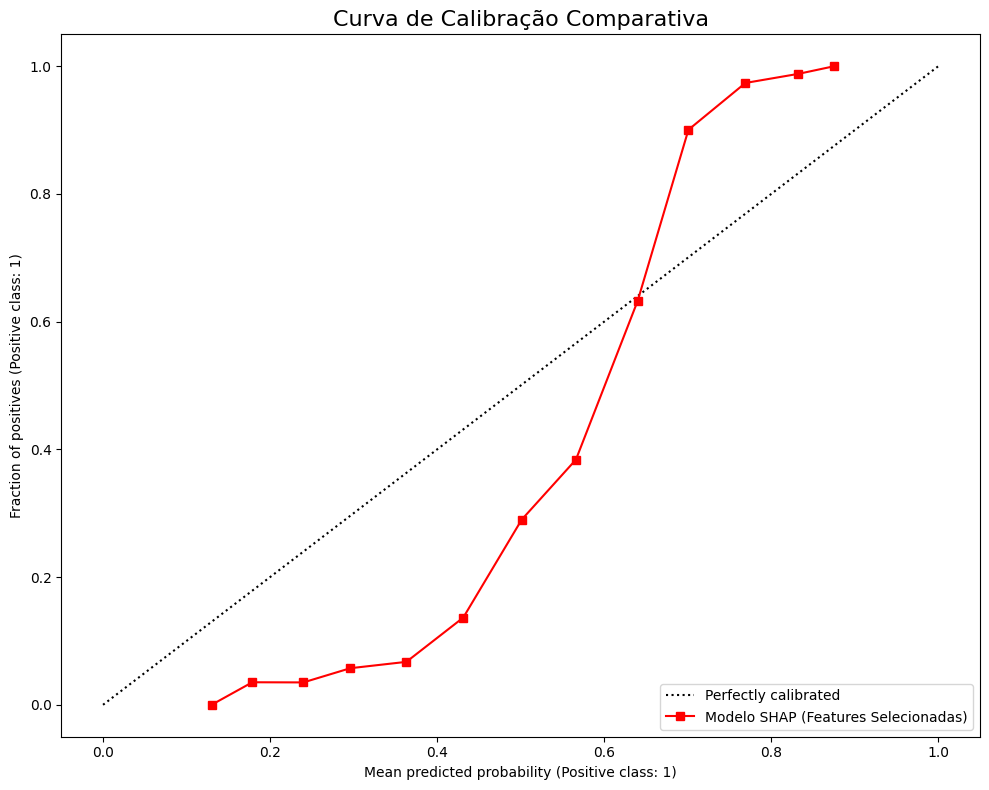

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], 
    n_bins=15,
    ax=ax,
    name="Modelo SHAP (Features Selecionadas)",
    color='red'
)

ax.set_title("Curva de Calibra√ß√£o Comparativa", fontsize=16)
plt.tight_layout()
plt.show()

O gr√°fico, com o formato de "S", retorna dois insights de neg√≥cio muito importantes sobre o modelo AdaBoost:

- **Confian√ßa nos Extremos**: O modelo √© excelente em identificar os extremos.
    - **Risco Baixo**: Quando ele prev√™ uma probabilidade baixa (ex: 20%), a chance real de evas√£o √© ainda menor (quase 0%). Isso significa que voc√™ pode confiar plenamente que os alunos classificados como de baixo risco est√£o, de fato, seguros.
    - **Risco Alto**: Quando ele prev√™ uma probabilidade alta (ex: 80%), a chance real de evas√£o √© ainda maior (quase 100%). Isso significa que os alunos no topo da lista de risco s√£o, com certeza, os casos mais cr√≠ticos.


Em que casos devemos calibrar o nosso modelo? 

- **Objetivo**: Se o objetivo da √°rea de neg√≥cios for "criar um programa de interven√ß√£o com diferentes n√≠veis de intensidade. Precisamos saber quais alunos t√™m mais de 80% de chance de evadir para uma tutoria individual, quais est√£o entre 60-80% para um workshop em grupo, e quais est√£o entre 50-60% para receber um e-mail de apoio", ent√£o a **calibra√ß√£o √© fundamental**.

- **Justificativa**: Para criar essas faixas e tomar decis√µes de neg√≥cio baseadas nelas, voc√™ precisa confiar que uma previs√£o de "80%" realmente corresponde a uma probabilidade pr√≥xima de 80% no mundo real. Um modelo n√£o calibrado √© superconfiante; ele pode dar uma probabilidade de 60% para um aluno cuja chance real de evas√£o √© de apenas 30%. Us√°-lo para criar faixas de risco levaria a uma aloca√ß√£o de recursos completamente equivocada.

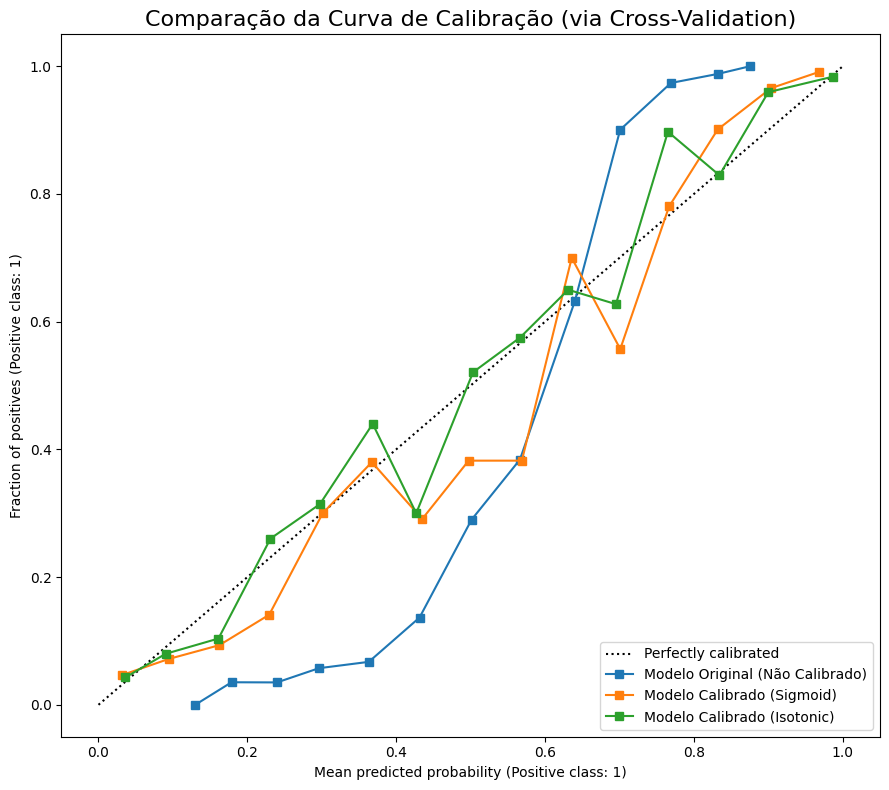

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

calibrated_sigmoid_pipeline_cv = CalibratedClassifierCV(
    pipeline_shap, 
    method='sigmoid', 
    cv=cv_strategy  # 3 folds internos para a calibra√ß√£o √© um bom valor, mais r√°pido.
)

calibrated_isotonic_pipeline_cv = CalibratedClassifierCV(
    pipeline_shap, 
    method='isotonic', 
    cv=cv_strategy
)

y_probas_sigmoid_calibrated_cv = cross_val_predict(
    calibrated_sigmoid_pipeline_cv,
    X_train,
    y_train,
    cv=cv_strategy,
    method='predict_proba',
)

y_probas_isotonic_calibrated_cv = cross_val_predict(
    calibrated_isotonic_pipeline_cv,
    X_train,
    y_train,
    cv=cv_strategy,
    method='predict_proba',
)

fig, ax = plt.subplots(figsize=(9, 8))

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_shap[:, 1], # Probabilidades da classe positiva
    n_bins=15, 
    ax=ax,
    name="Modelo Original (N√£o Calibrado)",
)

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_sigmoid_calibrated_cv[:, 1], 
    n_bins=15,
    ax=ax,
    name="Modelo Calibrado (Sigmoid)",
)

CalibrationDisplay.from_predictions(
    y_train, 
    y_probas_isotonic_calibrated_cv[:, 1], 
    n_bins=15,
    ax=ax,
    name="Modelo Calibrado (Isotonic)",
)

ax.set_title("Compara√ß√£o da Curva de Calibra√ß√£o (via Cross-Validation)", fontsize=16)
plt.tight_layout()
plt.show()

- **Modelo Original (Curva Azul)**: Confirma o que j√° sab√≠amos. O modelo base √© um √≥timo classificador (ele ordena bem os alunos por risco), mas um p√©ssimo estimador de probabilidades devido ao seu excesso de confian√ßa, com a curva em formato de "S" bem acentuado.

- **Modelo Calibrado (Sigmoid - Curva Laranja)**: Vemos uma melhora significativa. A calibra√ß√£o sigmoide (tamb√©m conhecida como Platt Scaling) fez um √≥timo trabalho em "suavizar" o excesso de confian√ßa do modelo, trazendo a curva para muito mais perto da linha diagonal ideal.

- **Modelo Calibrado (Isotonic - Curva Verde)**: √â a vencedora indiscut√≠vel. A curva de regress√£o isot√¥nica, por ser mais flex√≠vel e n√£o assumir uma forma espec√≠fica, conseguiu se ajustar quase perfeitamente aos dados. Em praticamente todas as faixas de probabilidade, a previs√£o do modelo calibrado corresponde √† realidade. O pequeno "zigue-zague" √© normal para este m√©todo, pois ele se ajusta aos dados de forma pontual.



Com uma calibra√ß√£o, n√≥s podemos transformar o modelo de um classificador bin√°rio em um sistema de gest√£o de risco.

Com as probabilidades calibradas pelo m√©todo isot√¥nico, a institui√ß√£o de ensino pode, com alta confian√ßa, implementar estrat√©gias de interven√ß√£o por faixas de risco (ex: Risco Alto > 80%, Risco M√©dio 60-80%), sabendo que esses n√∫meros correspondem fielmente √† realidade. Isso otimiza recursos, personaliza a abordagem e maximiza o impacto das a√ß√µes de reten√ß√£o.

## Avalia√ß√µes Finais (Dados de Teste)

#### Compara√ß√£o entre o modelo calibrado (isotonic) e o n√£o calibrado

--- Treinando e Avaliando os Modelos Finais no Conjunto de Teste ---
Processando: AdaBoost (N√£o Calibrado)...
Processando: AdaBoost (Calibrado Isotonic)...


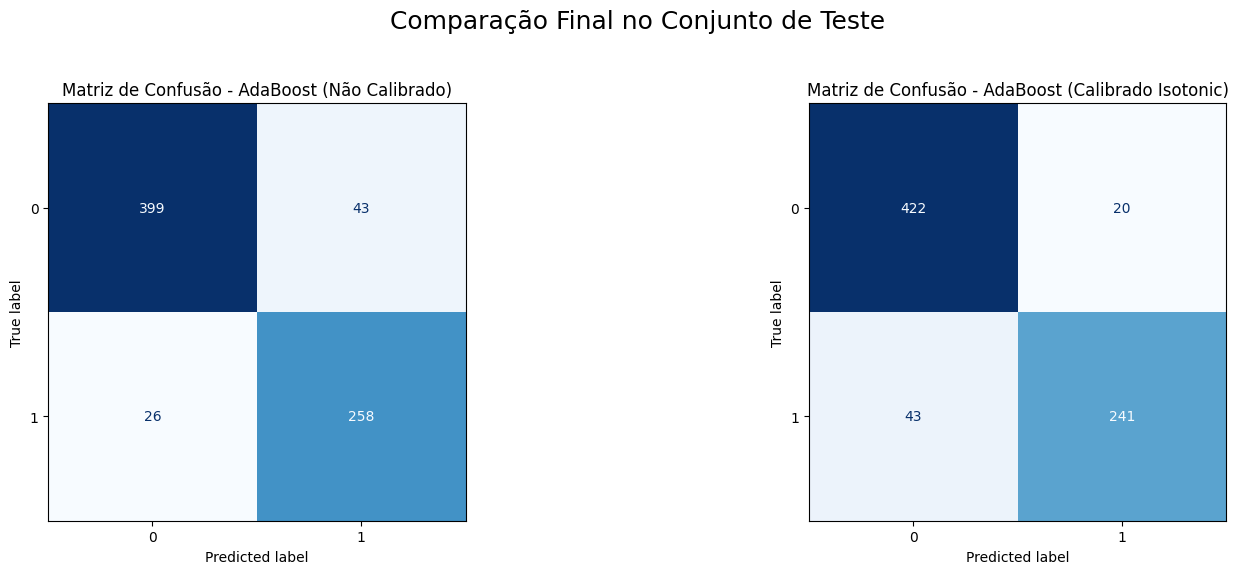


--- Tabela Comparativa de Performance Final ---


Precis√£o (Dropout)  Recall (Dropout)  \
AdaBoost (N√£o Calibrado)                   0.8571            0.9085   
AdaBoost (Calibrado Isotonic)              0.9234            0.8486   

                               F1-Score (Dropout)  
AdaBoost (N√£o Calibrado)                   0.8821  
AdaBoost (Calibrado Isotonic)              0.8844

In [233]:
pipelines_to_compare = {
    "AdaBoost (N√£o Calibrado)": pipeline_shap,
    "AdaBoost (Calibrado Isotonic)": calibrated_isotonic_pipeline_cv
}

final_results = {}
fitted_pipelines = {}


print("--- Treinando e Avaliando os Modelos Finais no Conjunto de Teste ---")
for name, pipeline in pipelines_to_compare.items():
    print(f"Processando: {name}...")
    
    fitted_model = pipeline.fit(X_train, y_train)
    fitted_pipelines[name] = fitted_model
    
    y_pred = fitted_model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    dropout_metrics = report.get('1', {}) # Foco na classe 'Dropout'
    
    final_results[name] = {
        'Precis√£o (Dropout)': dropout_metrics.get('precision', 0),
        'Recall (Dropout)': dropout_metrics.get('recall', 0),
        'F1-Score (Dropout)': dropout_metrics.get('f1-score', 0)
    }


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Compara√ß√£o Final no Conjunto de Teste', fontsize=18)

for i, (name, pipeline) in enumerate(fitted_pipelines.items()):
    ax = axes[i]
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Matriz de Confus√£o - {name}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


results_df = pd.DataFrame.from_dict(final_results, orient='index')
results_df = results_df.round(4)

print("\n--- Tabela Comparativa de Performance Final ---")
display(results_df)

O resultado √© um cl√°ssico trade-off:

| M√©trica / Caracter√≠stica           | Modelo N√£o Calibrado           | Modelo Calibrado (Isotonic)   |
|-----------------------------------|--------------------------------|-------------------------------|
| Recall (Detec√ß√£o)                 | **0.9085 (Superior)**          | 0.8486                        |
| Precis√£o (Efici√™ncia)            | 0.8571                         | **0.9234 (Superior)**         |
| F1-Score (Equil√≠brio)             | 0.8821                         | **0.8844 (Ligeiramente Superior)** |
| Confiabilidade da Probabilidade   | Baixa (Superconfiante)         | **Alta (Realista)**           |


- O Modelo N√£o Calibrado √© a nossa melhor "rede de seguran√ßa". Ele √© superior em encontrar o maior n√∫mero poss√≠vel de alunos em risco (**Recall mais alto**).
- O Modelo Calibrado √© a nossa ferramenta de "alta efici√™ncia". Ele gera muito menos alarmes falsos, garantindo que o tempo da equipe de apoio seja melhor aproveitado (**Precis√£o mais alta**).

##### Cen√°rios de Aplica√ß√£o: Qual Modelo para Qual Estrat√©gia?

A escolha entre os dois modelos n√£o √© t√©cnica, mas sim uma decis√£o de neg√≥cio baseada nos recursos e na filosofia da institui√ß√£o.

Cen√°rio A: "Estrat√©gia de Ranking e Alcance M√°ximo" - Escolhendo o Modelo N√£o Calibrado

Quando usar: Se o objetivo principal da institui√ß√£o √© simplesmente gerar uma lista ordenada de alunos com maior risco para que uma equipe de apoio possa contat√°-los sequencialmente, do mais prov√°vel ao menos prov√°vel.
Como funciona: Neste cen√°rio, o valor exato da probabilidade n√£o √© t√£o importante quanto o ranking que ela gera. O modelo n√£o calibrado, com seu Recall superior de quase 91%, √© a melhor ferramenta para garantir que a "rede de seguran√ßa" seja a maior poss√≠vel, capturando o m√°ximo de alunos que precisam de ajuda.
Vantagem: M√°xima detec√ß√£o de casos de risco.
Desvantagem: A equipe de apoio lidar√° com mais "alarmes falsos" (precis√£o de 86%), e n√£o ser√° poss√≠vel diferenciar um aluno com "muito risco" de um com "risco extremo" com base na probabilidade.


Cen√°Cen√°rio B: "Estrat√©gia de Gest√£o de Risco por N√≠veis" - Escolhendo o Modelo Calibrado

Quando usar: Se a institui√ß√£o deseja criar uma estrat√©gia de interven√ß√£o sofisticada, segmentada e baseada em n√≠veis de urg√™ncia, alocando recursos de forma mais inteligente.
Como funciona: Com as probabilidades confi√°veis e realistas do modelo calibrado, a institui√ß√£o pode criar faixas de a√ß√£o com seguran√ßa:
    Risco Cr√≠tico (Probabilidade > 80%): Interven√ß√£o imediata e pessoal por um conselheiro s√™nior.
    Risco Alto (Probabilidade 60-80%): Convoca√ß√£o para um workshop de apoio ou tutoria em grupo.
    Risco Moderado (Probabilidade 50-60%): Envio de um e-mail informativo com recursos e canais de ajuda.
Vantagem: Esta abordagem √© muito mais eficiente e personalizada. Ela n√£o apenas prev√™, mas quantifica o risco de forma confi√°vel.
Desvantagem: Aceita-se que a "rede de seguran√ßa" total √© um pouco menor (Recall de 85%).

##### Conclus√£o:

Ap√≥s uma an√°lise detalhada da performance dos modelos finais no conjunto de teste, a decis√£o estrat√©gica √© selecionar o Modelo AdaBoost N√£o Calibrado como a solu√ß√£o a ser implementada.

Essa escolha √© guiada pela m√©trica que √© geralmente a mais cr√≠tica para o problema de evas√£o estudantil para a maioria das institui√ß√µes de ensino: o Recall. Falsos negativos podem ter um impacto muito maior do que falsos positivos e/ou previs√£o de probabilidades destoantes. O modelo n√£o calibrado alcan√ßou um impressionante Recall de 90.9% para a classe Dropout, superando a vers√£o calibrada.

Na pr√°tica, isso significa que este modelo √© a ferramenta mais eficaz para cumprir o objetivo principal de uma institui√ß√£o de ensino, que √© minimizar o n√∫mero de Falsos Negativos e garantir que o menor n√∫mero poss√≠vel de alunos em risco passe despercebido.

Embora isso implique uma precis√£o ligeiramente menor (mais "alarmes falsos"), a prioridade de maximizar a "rede de seguran√ßa" e oferecer uma oportunidade de ajuda a quase 91% dos alunos que evadiriam justifica essa troca. Portanto, o modelo recomendado √© aquele que prioriza o alcance e a capacidade de detec√ß√£o, alinhando-se diretamente com uma estrat√©gia de reten√ß√£o estudantil proativa e de m√°ximo impacto.

In [236]:
final_model = pipelines_to_compare["AdaBoost (N√£o Calibrado)"]
final_model

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('feature_selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['Application order',
                                                   'Curricular units 2nd sem '
                                                   '(credited)',
                                                   'Curricular units 2nd sem '
                                                   '(evaluations)',
                                                   'Inflation rate',
                                                   'indice_estresse_financeiro',
                                                   'desvio_nota_1sem',
                                                   'desvio_nota_2sem',
                                                   'taxa_aprovacao_1sem',
                                                   'taxa_aprovacao_2...
                                                   "Mother's "
                                                   'occupation_encoded',
                                                   'interacao_curso_genero_encoded',
                                                   'Tuition fees up to '
                                                   'date_1'])])),
                ('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=2,
                                                                     random_state=42),
                                    learning_rate=0.0432315460587612,
                                    n_estimators=861, random_state=42))])

### An√°lise efici√™ncia do modelo

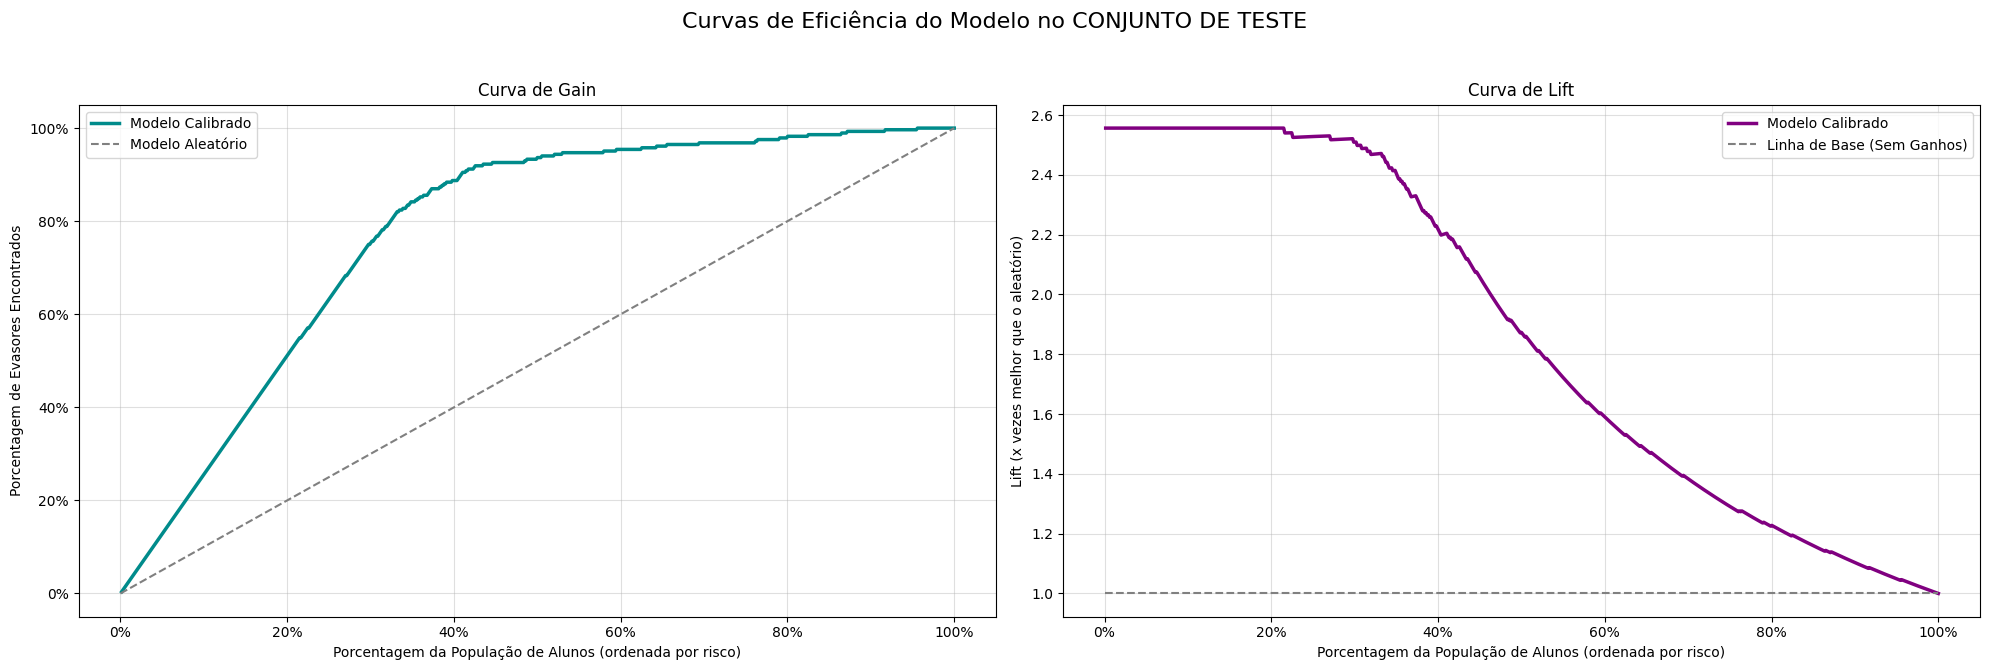

In [237]:
y_probas_test = final_model.predict_proba(X_test)

y_scores = y_probas_test[:, 1]

df_results_test = pd.DataFrame({'y_true': y_test, 'y_score': y_scores})
df_results_test = df_results_test.sort_values(by='y_score', ascending=False)

df_results_test['cumulative_positives'] = df_results_test['y_true'].astype(int).cumsum()
total_positives = df_results_test['y_true'].astype(int).sum()
df_results_test['gain'] = df_results_test['cumulative_positives'] / total_positives

df_results_test['population_percentage'] = np.arange(1, len(df_results_test) + 1) / len(df_results_test)
df_results_test['lift'] = df_results_test['gain'] / df_results_test['population_percentage']

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Curvas de Efici√™ncia do Modelo no CONJUNTO DE TESTE', fontsize=16)

axes[0].plot(df_results_test['population_percentage'], df_results_test['gain'], label='Modelo Calibrado', color='darkcyan', lw=2.5)
axes[0].plot([0, 1], [0, 1], label='Modelo Aleat√≥rio', color='grey', linestyle='--')
axes[0].set_xlabel("Porcentagem da Popula√ß√£o de Alunos (ordenada por risco)")
axes[0].set_ylabel("Porcentagem de Evasores Encontrados")
axes[0].set_title('Curva de Gain')
axes[0].legend()
axes[0].grid(True, alpha=0.4)
axes[0].xaxis.set_major_formatter(PercentFormatter(1.0))
axes[0].yaxis.set_major_formatter(PercentFormatter(1.0))

axes[1].plot(df_results_test['population_percentage'], df_results_test['lift'], label='Modelo Calibrado', color='purple', lw=2.5)
axes[1].plot([0, 1], [1, 1], label='Linha de Base (Sem Ganhos)', color='grey', linestyle='--')
axes[1].set_xlabel("Porcentagem da Popula√ß√£o de Alunos (ordenada por risco)")
axes[1].set_ylabel("Lift (x vezes melhor que o aleat√≥rio)")
axes[1].set_title('Curva de Lift')
axes[1].legend()
axes[1].grid(True, alpha=0.4)
axes[1].xaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### Interpreta√ß√£o da Curva de Gain (O "Quanto Encontramos")

O gr√°fico √† esquerda mostra o qu√£o r√°pido o modelo consegue encontrar os alunos que realmente pertencem √† classe Dropout.

- **Ponto Chave 1 (Efici√™ncia M√°xima)**: Ao focar nos 20% dos alunos com maior risco apontados pelo modelo, a institui√ß√£o consegue encontrar e atuar sobre aproximadamente 50% de todos os alunos que iriam evadir.
- **Ponto Chave 2 (Cobertura Ampla)**: Com um esfor√ßo um pouco maior, contatando os 40% de maior risco, a equipe de apoio j√° alcan√ßaria cerca de 90% do p√∫blico-alvo (os futuros evasores).

**Insight Estrat√©gico**: Isso demonstra uma √≥tima efici√™ncia. A institui√ß√£o n√£o precisa de uma abordagem que "atire para todos os lados". Com um esfor√ßo focado em menos da metade da popula√ß√£o estudantil em risco, √© poss√≠vel cobrir mais de 90% do problema da evas√£o.

#### Interpreta√ß√£o da Curva de Lift (O "Qu√£o Melhores Somos")

O gr√°fico √† direita quantifica o poder do modelo em compara√ß√£o com uma abordagem aleat√≥ria.

- **Ponto Chave 1 (Lift Inicial)**: O "lift" inicial de aproximadamente 2.6 significa que um aluno escolhido do topo da lista de risco do modelo tem 2.6 vezes mais chance de ser um evasor real do que um aluno escolhido ao acaso da popula√ß√£o geral.
- **Ponto Chave 2 (Lift Sustentado)**: O lift se mant√©m bem acima de 2.0 mesmo quando consideramos 30-40% da popula√ß√£o. Isso mostra que o modelo n√£o √© bom apenas em encontrar os casos √≥bvios, mas tamb√©m em ranquear eficientemente os alunos de risco moderado.

**Insight Estrat√©gico**: O modelo √© um "multiplicador de efici√™ncia" para a equipe de apoio. Cada hora de trabalho gasta contatando alunos da lista do modelo √©, em m√©dia, 2.5 vezes mais produtiva do que seria com uma abordagem n√£o direcionada.

#### Conclus√£o

Com base nesses gr√°ficos, um gestor pode decidir: "Neste semestre, temos recursos para intervir ativamente em 30% dos nossos alunos. O modelo nos garante que, ao fazer isso, estaremos alcan√ßando cerca de 80% do nosso problema real de evas√£o, o que √© um √≥timo retorno sobre o investimento".

# Explicabilidade do Modelo

## SHAP

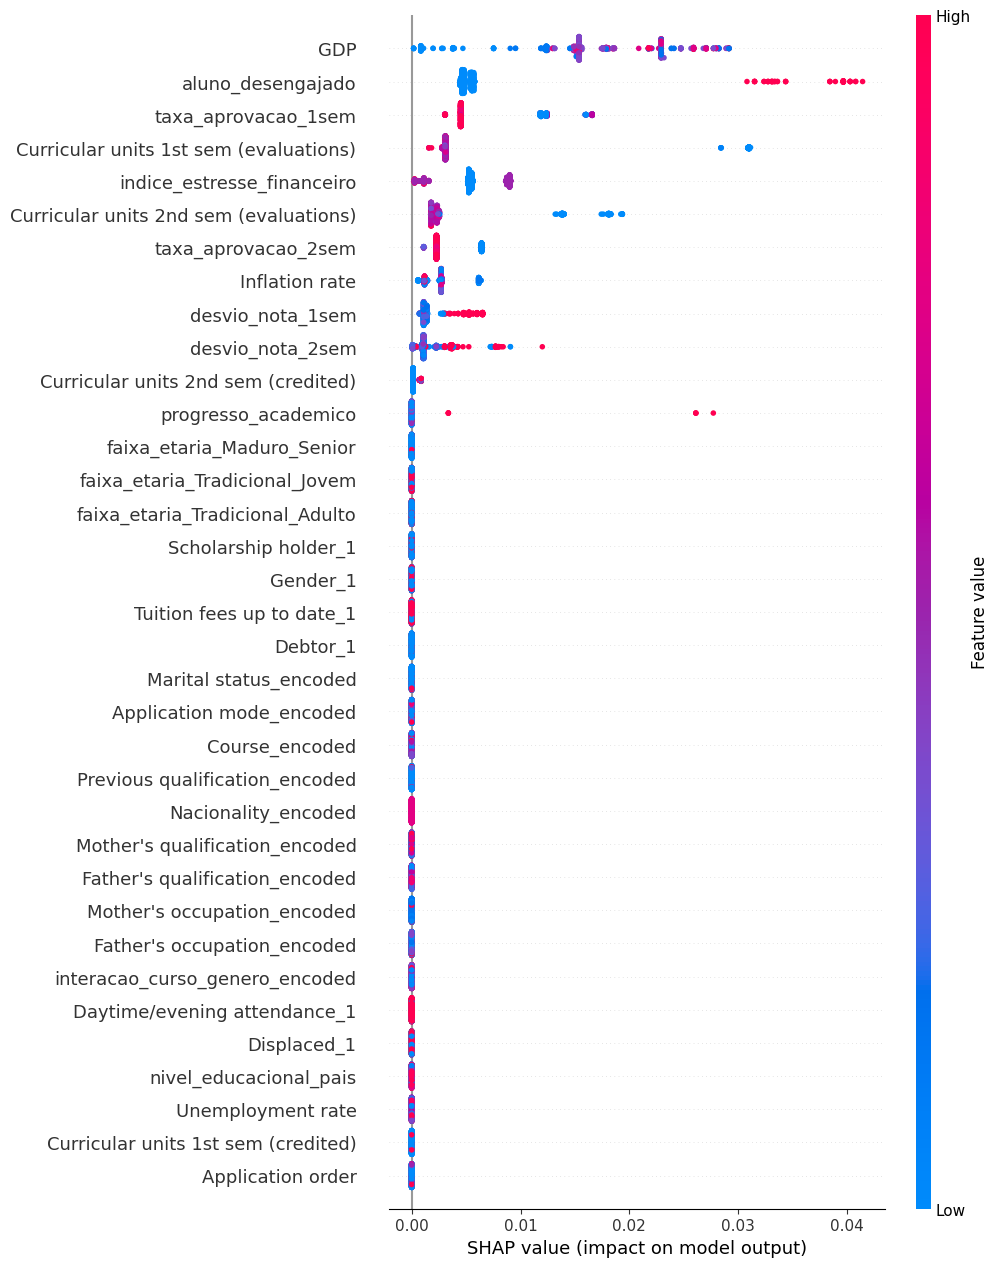

In [239]:
shap.initjs()

final_model_pipeline = final_model.fit(X_train, y_train)
feature_engineer_trained = final_model.named_steps['feature_engineer']

X_train_final_df = feature_engineer_trained.transform(X_train)
X_test_final_df = feature_engineer_trained.transform(X_test)

classifier_trained = final_model.named_steps['classifier']

explainer = shap.Explainer(classifier_trained, X_train_final_df)
shap_values = explainer(X_test_final_df)

shap.plots.beeswarm(shap_values[:, :, 1].abs, max_display=35)